# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

sum_sq    df         F    PR(>F)  p_val_adj
A1BG   0.122578  12.0  2.796490  0.003701   0.010364
AAAS   0.017527  12.0  0.944161  0.509517   0.596369
AACS   0.136394  12.0  2.729393  0.004508   0.012212
AADAT  0.057031  12.0  5.478881  0.000002   0.000016
AAGAB  0.043359  12.0  2.127609  0.026045   0.053640

In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = '../../data/pseudobulks/'

In [8]:
os.listdir(pb_dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

## Specie-specific genes

In [11]:
import pickle
with open("./results/specie_specific_genes_tr50.pkl", "rb") as file:
    genes_dict77 = pickle.load(file)

## Helpful functions

In [12]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [13]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [14]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [15]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [16]:
hs_genes = genes_dict77['human']

In [17]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes]

## Hierarchial

D:\Projects\spatialMPFC\venv\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


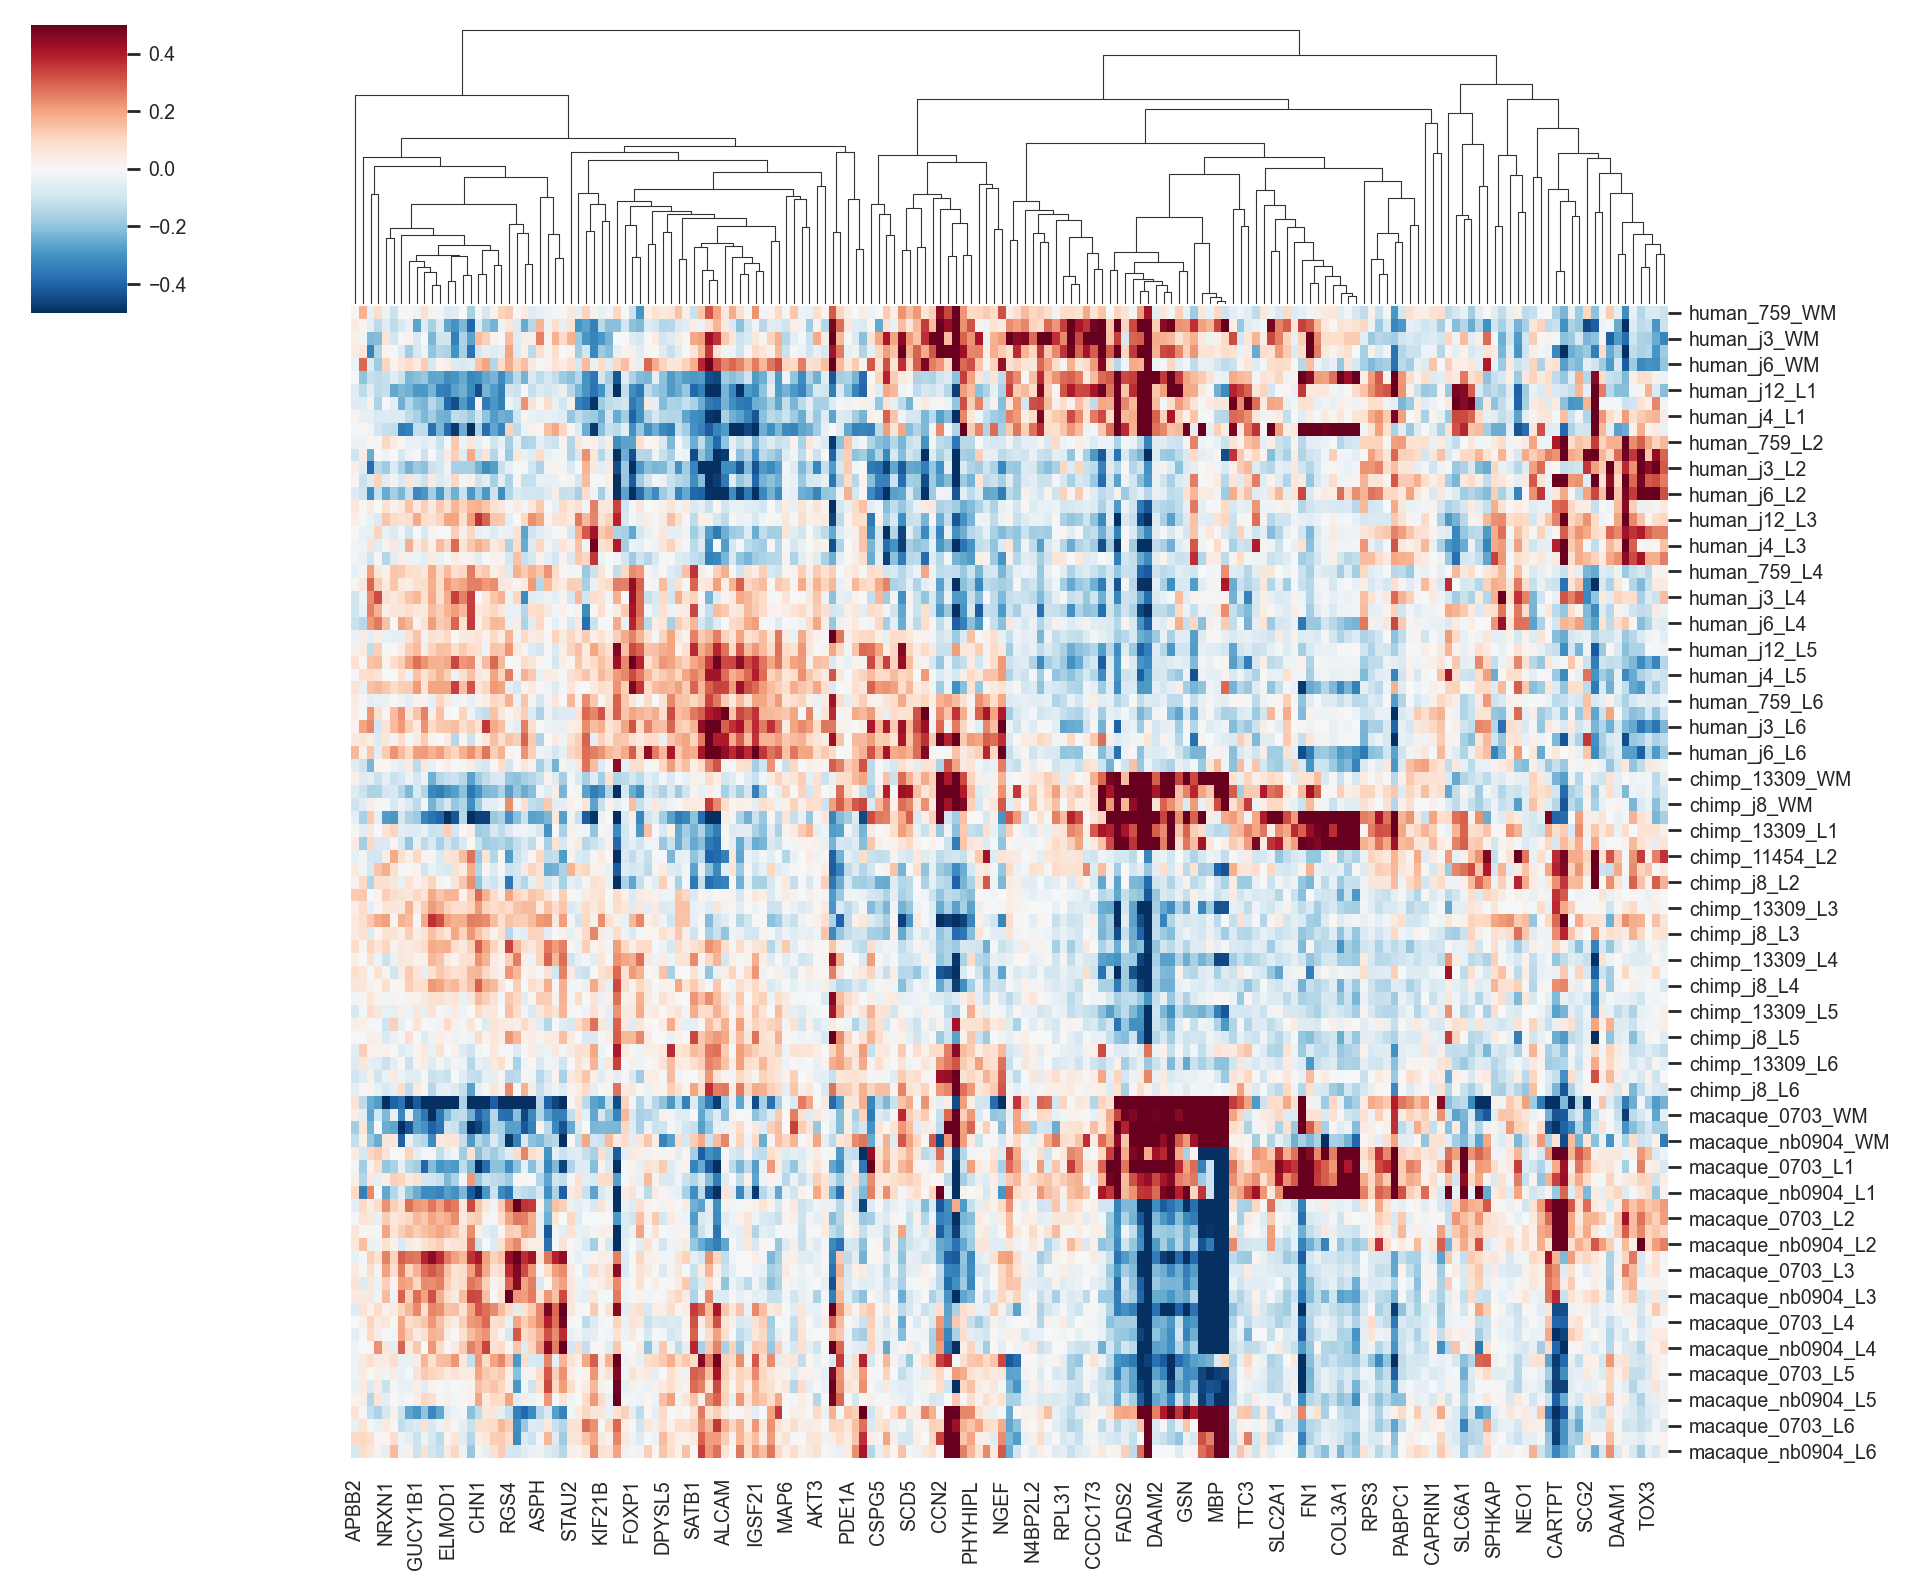

In [18]:
sns.set(font_scale=0.8)
sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.5, vmin=-0.5, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [72]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_hs.T, metric='cosine') + 1
n_clusters = 4
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)

SpectralClustering(affinity='precomputed', gamma=1, n_clusters=4,
                   random_state=4)

In [73]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [74]:
labels.to_csv('./results/human_clusters_50.csv')

In [75]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [76]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

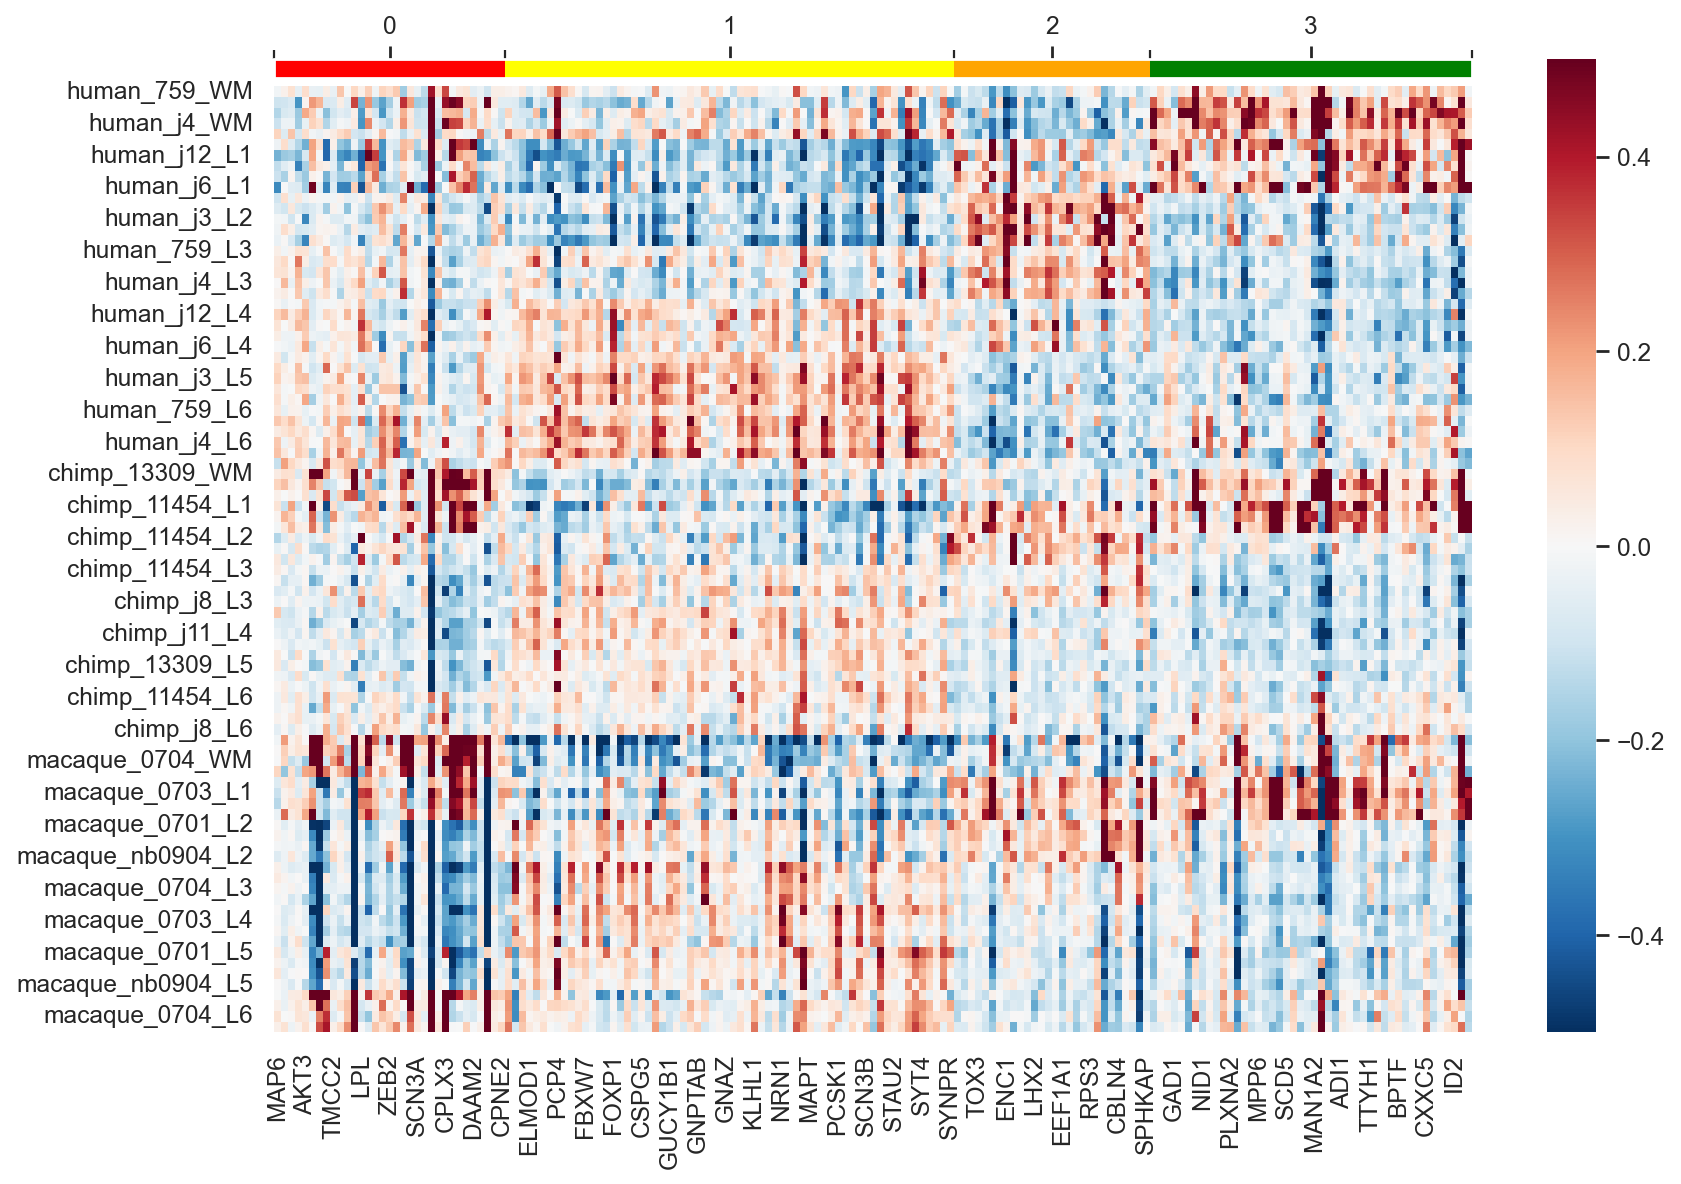

In [77]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_hs[order], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

In [78]:
labels[labels == 1].size

64

## Cluster profiles (mean)

In [79]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [80]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ACTA2      ADI1      AKT3     ALCAM      ANK2     APBB2  \
condition layer                                                               
chimp     L1     0.728220  0.232106 -0.012988  0.009130 -0.074303  0.000521   
          L2    -0.127487 -0.029761 -0.013202 -0.242804 -0.107423  0.009758   
          L3    -0.095616 -0.081698  0.004795 -0.066325 -0.046509  0.064595   
          L4    -0.111591 -0.069586 -0.005160  0.006249 -0.037624  0.065062   
          L5    -0.077636 -0.055009 -0.032334  0.134409 -0.015614 -0.020785   

                   APCDD1     APLP2       APP      AQP4  ...      TSPO  \
condition layer                                          ...             
chimp     L1     0.438053 -0.006447 -0.143722  0.764710  ...  0.040045   
          L2    -0.015450 -0.034986 -0.104327 -0.096835  ... -0.052895   
          L3    -0.180579 -0.042810  0.091190 -0.409157  ... -0.039607   
          L4    -0.162720 -0.058964  0.091682 -0.409665  ... -0.063044   
          L5    -0.139614  0.015875  0.062882 -0.282063  ... -0.015141   

                     TTC3     TTYH1    TUBA4A     UBAP2     VAT1L    VSTM2A  \
condition layer                                                               
chimp     L1     0.146501  0.071092 -0.190006  0.001697 -0.134595  0.077321   
          L2    -0.025527  0.014022 -0.271730  0.053347 -0.027984  0.210841   
          L3    -0.097487  0.005924 -0.212395 -0.041216 -0.090556  0.094489   
          L4    -0.118147 -0.032925  0.030377  0.017843 -0.019777  0.014245   
          L5    -0.079551 -0.050280  0.149852 -0.056467  0.138460 -0.087230   

                   ZBTB18      ZEB2    ZMYND8  
condition layer                                
chimp     L1    -0.154330  0.037896 -0.001521  
          L2     0.229193  0.051170  0.059591  
          L3     0.178206 -0.040480  0.063579  
          L4     0.129230 -0.075607  0.019230  
          L5     0.023022 -0.057856 -0.050828  

[5 rows x 171 columns]

Text(0.5, 0.98, 'Mean everaging for profiles')

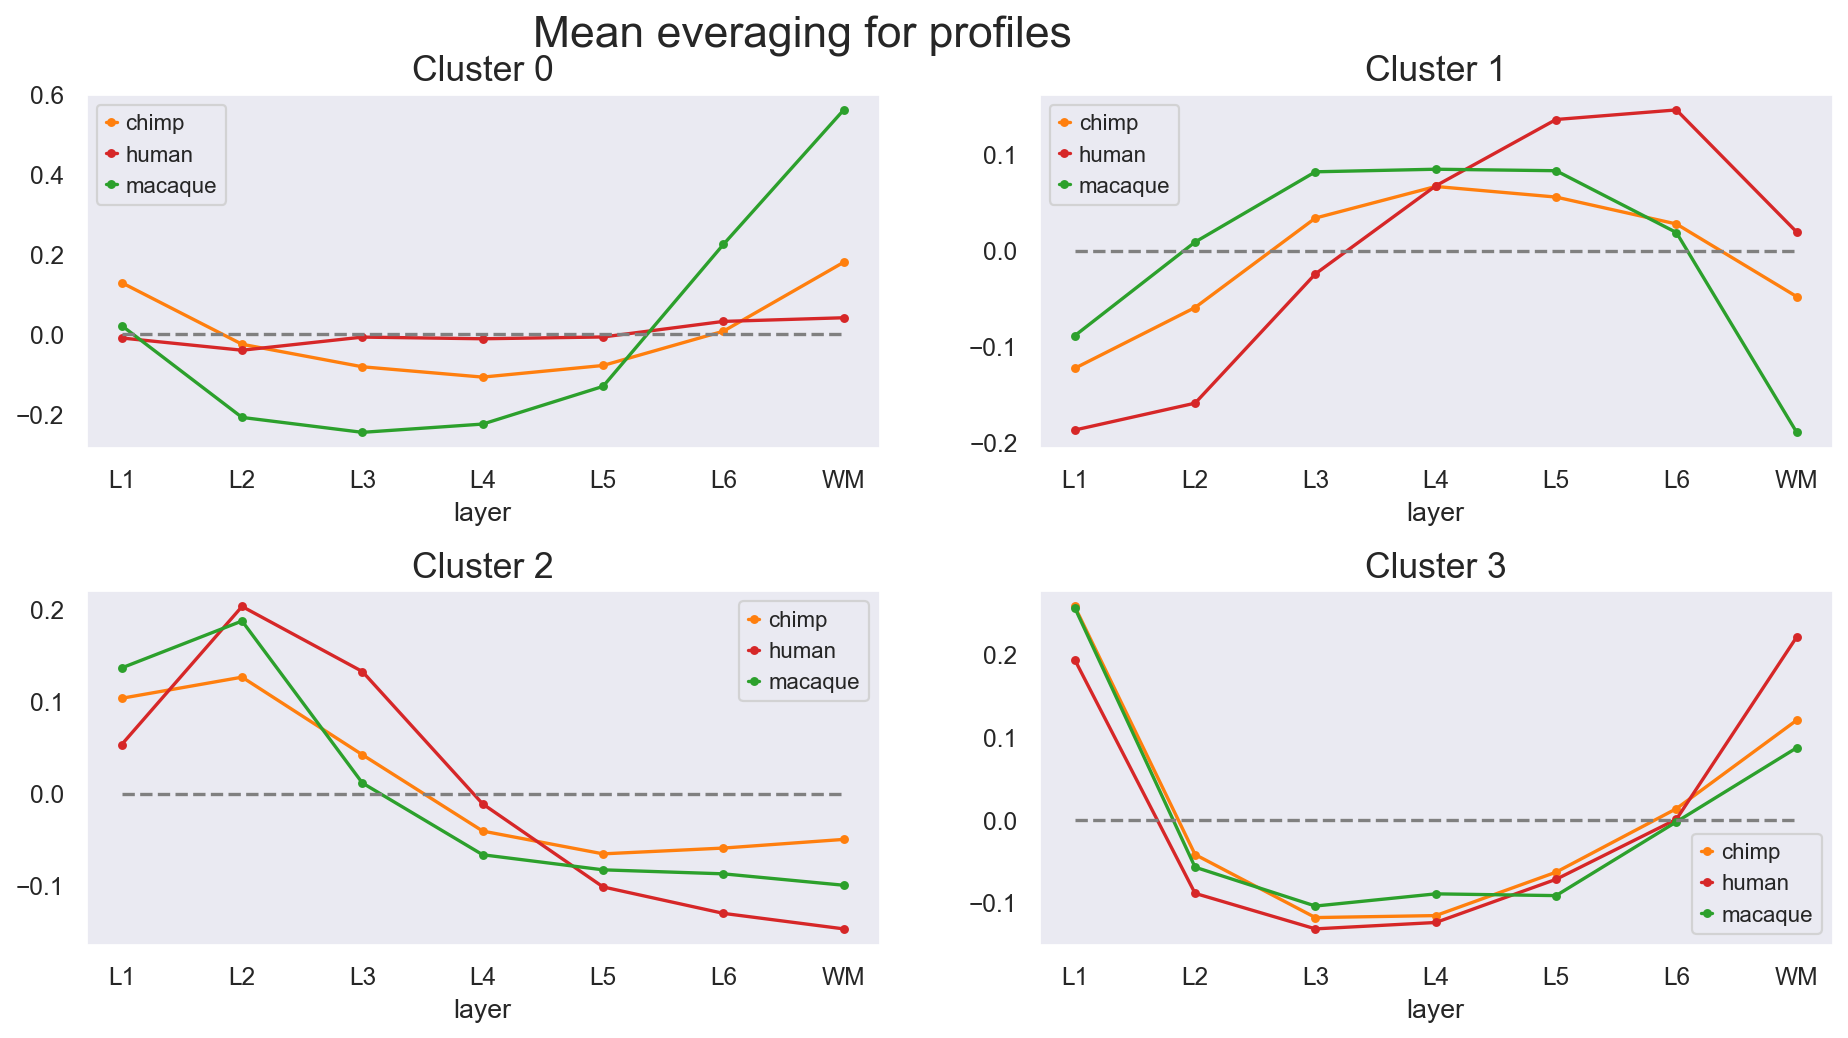

In [81]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Mean everaging for profiles', fontsize=20)

## Cluster profiles (Median)

Text(0.5, 0.98, 'Median everaging for profiles')

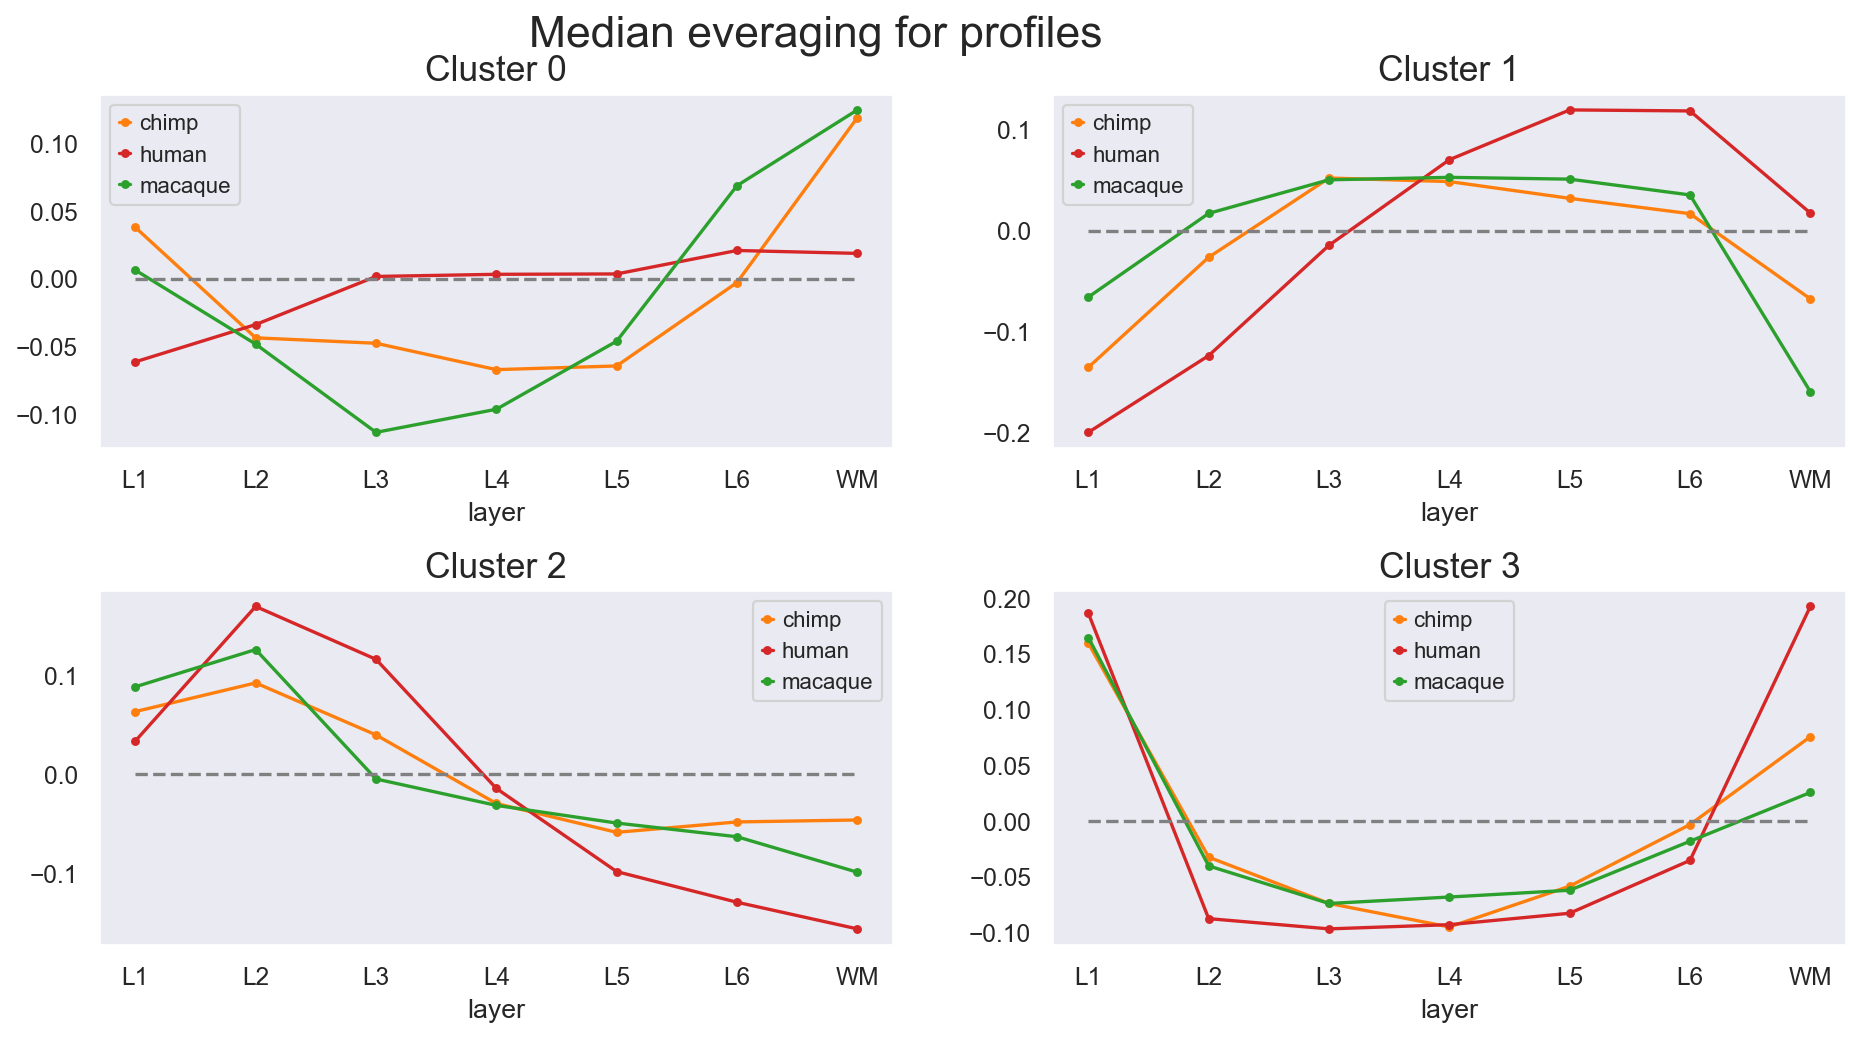

In [82]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median everaging for profiles', fontsize=20)

# 4 Species

In [83]:
pb_dir_path = '../../data/pseudobulks/'
adata_pb_4spe = sc.read_h5ad(pb_dir_path + '4spe_pb_mean_filt_nor_mean.h5ad')
#adata_pb_4spe = sc.read_h5ad('results/adata_4spe.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_4spe

AnnData object with n_obs × n_vars = 116 × 6523
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    var: 'gene_name'
    uns: 'log1p'

In [84]:
df_4spe = pd.DataFrame(adata_pb_4spe.X, index=adata_pb_4spe.obs_names, columns=adata_pb_4spe.var_names)

In [85]:
hs_genes_inter = df_4spe.columns.intersection(hs_genes)
hs_genes_inter.size

115

In [86]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque', 'treeshrew']:
    samples = df_4spe.loc[df_4spe.index.str.contains(cond)].index
    order_s = sorted(samples.tolist(), key=lambda x: x[:2])
    order_laminar = list(filter(lambda x: 'L' in x, order_s))
    order_wm = list(filter(lambda x: 'WM' in x, order_s))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['treeshrew']
df_4spe = df_4spe.loc[sample_order['all']]
df_4spe_hs = df_4spe[hs_genes_inter]

In [87]:
order_4spe = order.intersection(hs_genes_inter)

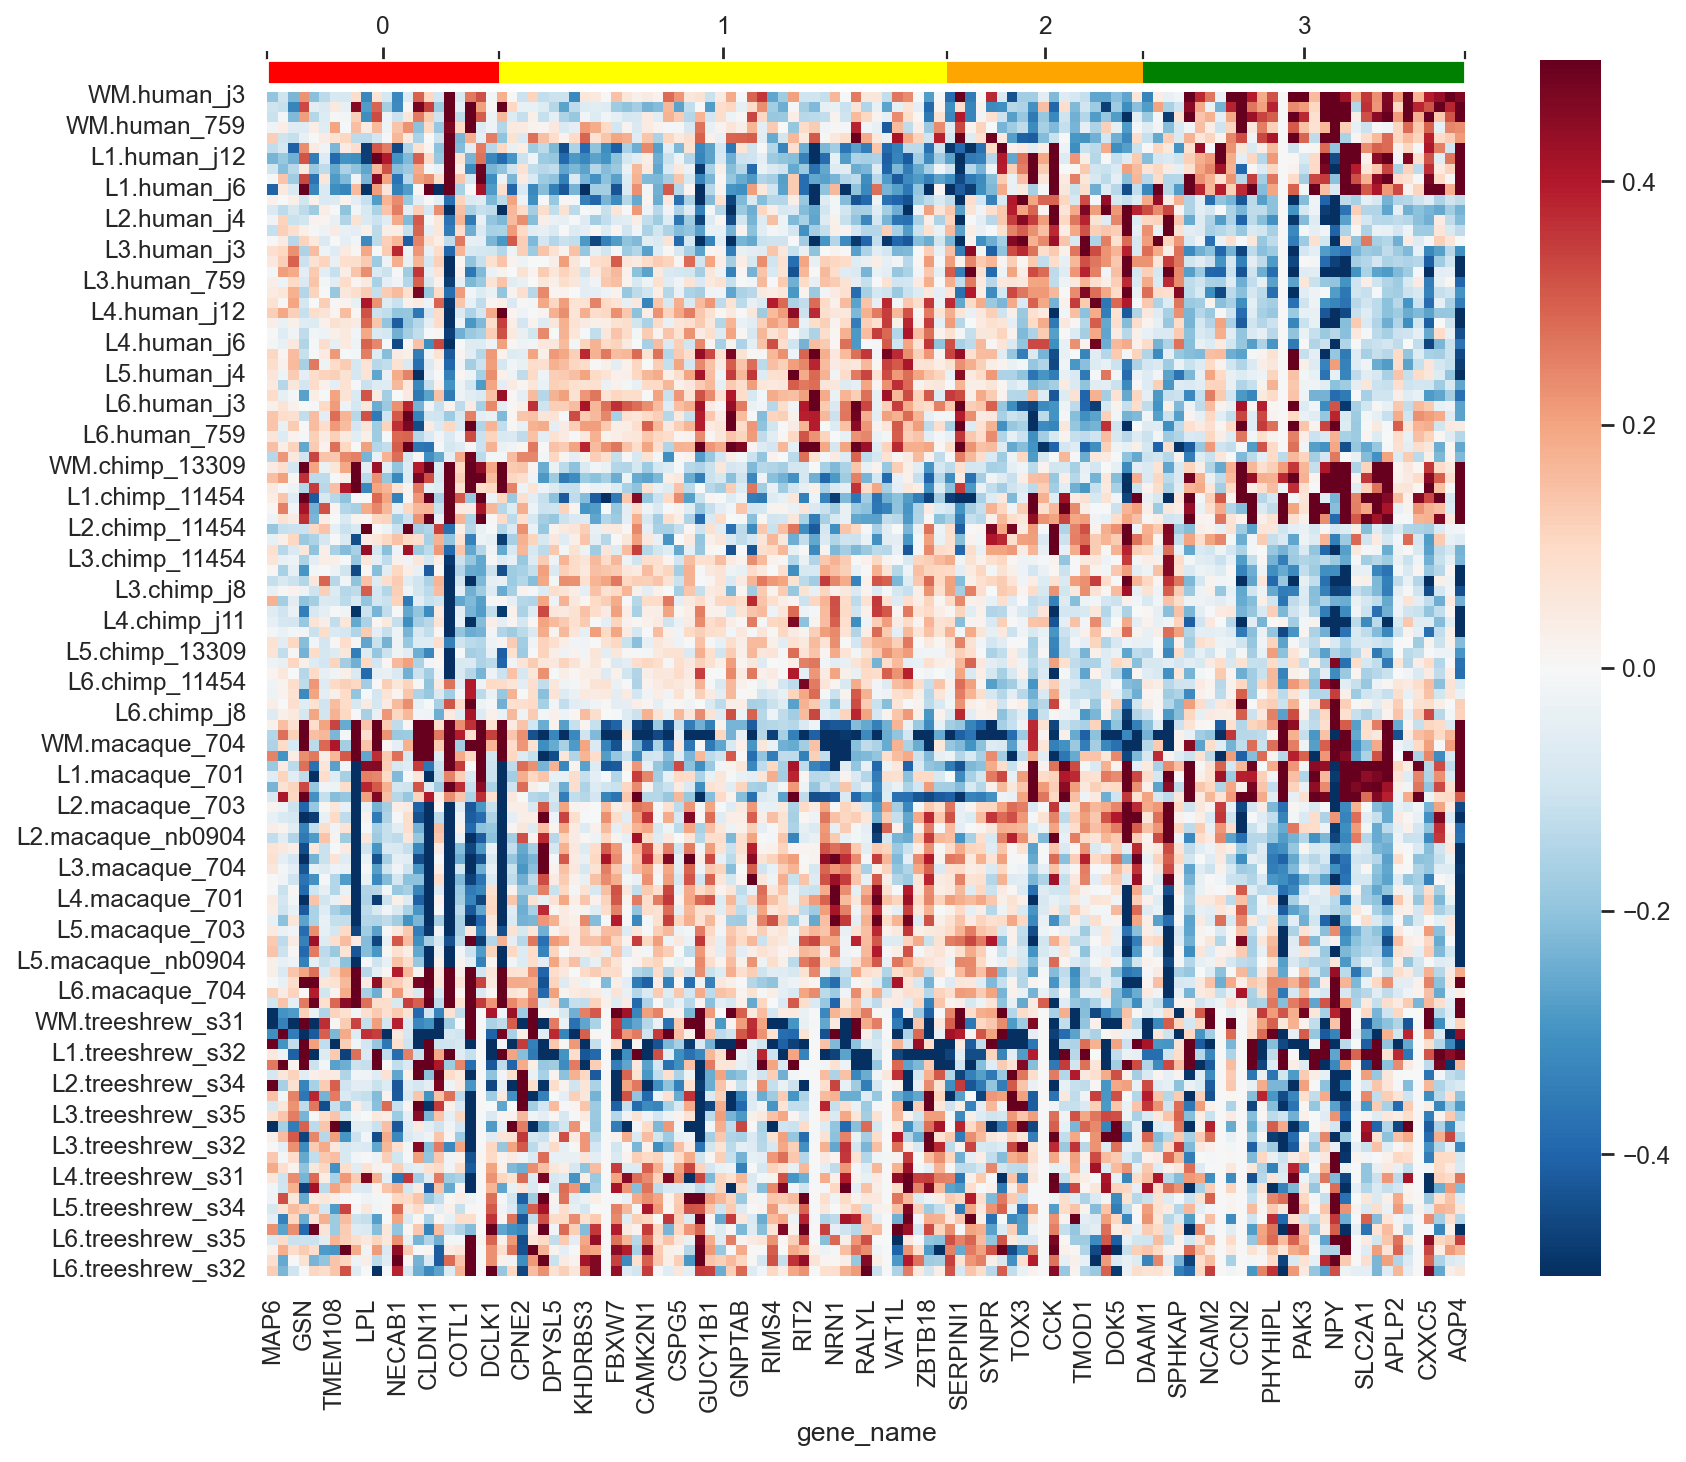

In [88]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_4spe_hs[order_4spe], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

## Cluster profiles (mean)

In [89]:
df_annotation = df_4spe_hs.copy()
df_annotation['layer'] = adata_pb_4spe.obs.layer
df_annotation['condition'] = adata_pb_4spe.obs.condition

In [90]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

gene_name          IGSF21   CAMK2N1    SLC2A1    MAN1A2   S100A10      RGS4  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.231617 -0.100126  0.549012  0.226507  0.025641 -0.215088   
          L2    -0.164320 -0.045536 -0.105929 -0.075494 -0.004033 -0.280267   
          L3    -0.013440  0.078886 -0.085139 -0.287561 -0.141873  0.079573   
          L4     0.176425  0.037796 -0.159376 -0.323849  0.201904  0.192206   

gene_name          KIF21B     TMCC2      NID1    ZBTB18  ...     KCNG1  \
condition layer                                          ...             
chimp     6a          NaN       NaN       NaN       NaN  ...       NaN   
          L1    -0.061434  0.090244  0.772159 -0.137080  ... -0.163782   
          L2     0.055080  0.029616 -0.101655  0.238887  ...  0.003626   
          L3     0.114423  0.110009 -0.183162  0.185809  ...  0.160608   
          L4     0.066458 -0.001428 -0.167780  0.131912  ...  0.056947   

gene_name            DOK5     CBLN4   TMEM59L      ETFB      GNAZ      TSPO  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.012182  0.309610 -0.141558  0.162136 -0.039300  0.156637   
          L2     0.176226  0.122471 -0.012853 -0.038228  0.123926 -0.074830   
          L3     0.072969  0.016419  0.074497 -0.048922  0.102861 -0.067673   
          L4    -0.025213 -0.012583  0.036490  0.016441  0.079627 -0.098315   

gene_name           NCAM2      JAM2       APP  
condition layer                                
chimp     6a          NaN       NaN       NaN  
          L1     0.075177  0.285189 -0.117498  
          L2     0.041594 -0.111063 -0.100191  
          L3    -0.014084 -0.064058  0.082678  
          L4    -0.011287 -0.068254  0.083122  

[5 rows x 115 columns]

Text(0.5, 0.98, 'Mean everaging for profiles')

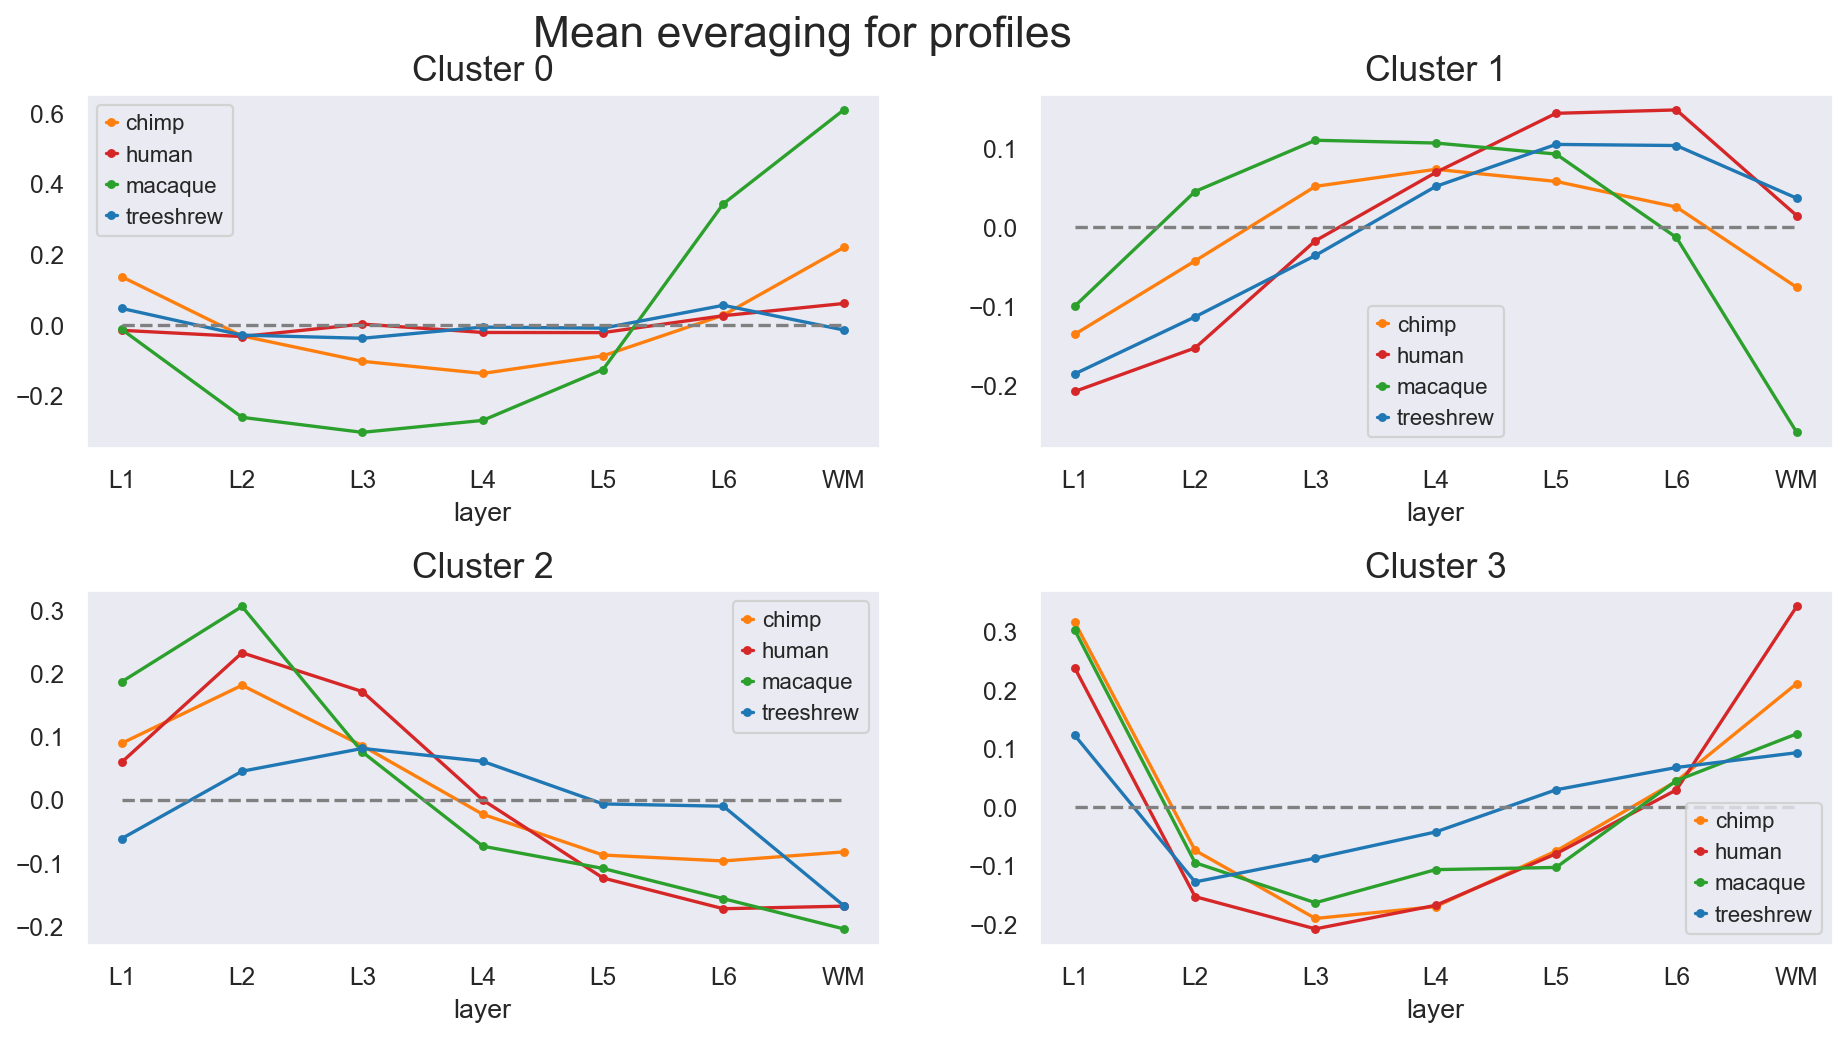

In [91]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Mean everaging for profiles', fontsize=20)

## Cluster profiles (Median)

Text(0.5, 0.98, 'Median everaging for profiles')

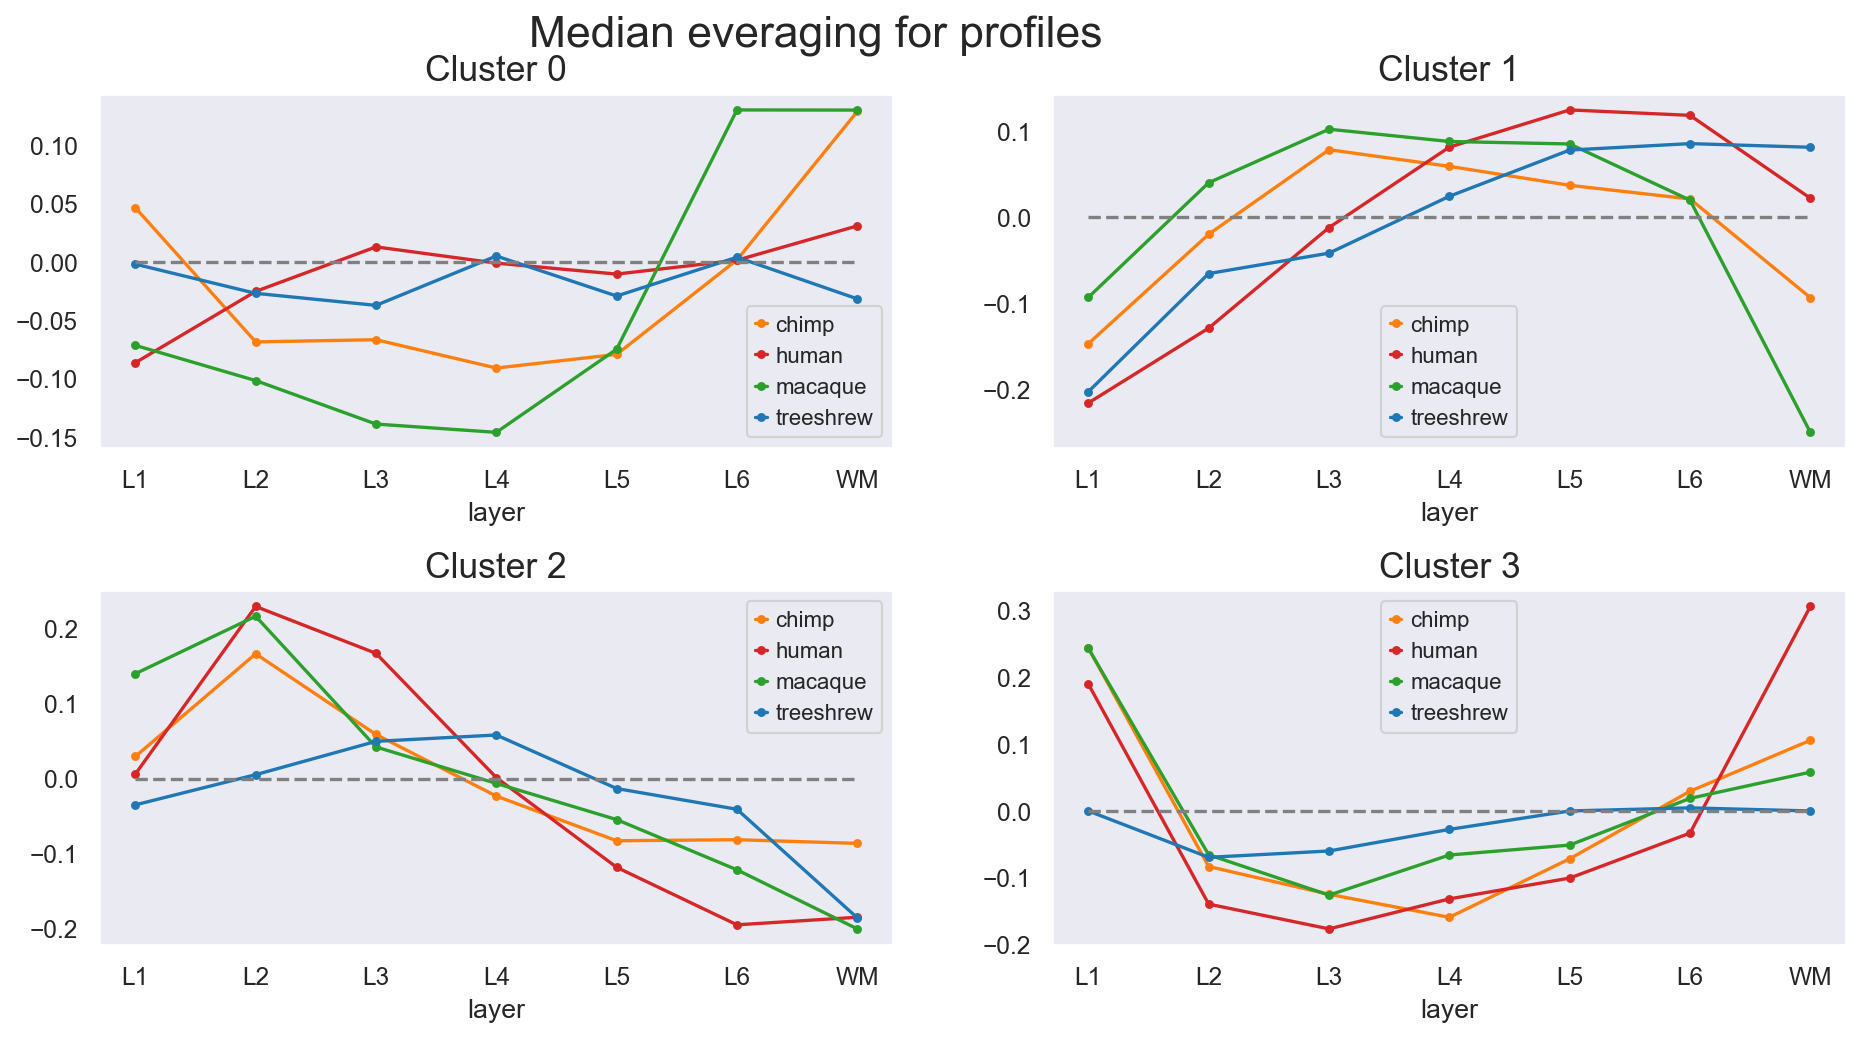

In [92]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(hs_genes_inter).tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median everaging for profiles', fontsize=20)

# Intersection with ANOVA clusters

In [93]:
anova_hs_inter = hs_genes.intersection(anova_labels.index)
anova_hs_inter

Index(['ACTA2', 'ADI1', 'AKT3', 'ALCAM', 'ANK2', 'APBB2', 'APCDD1', 'APLP2',
       'APP', 'AQP4',
       ...
       'TSPO', 'TTC3', 'TTYH1', 'TUBA4A', 'UBAP2', 'VAT1L', 'VSTM2A', 'ZBTB18',
       'ZEB2', 'ZMYND8'],
      dtype='object', length=159)

In [94]:
table_to_pivot = pd.concat([anova_labels.loc[anova_hs_inter], labels.loc[anova_hs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels        0     1     2     3
ANOVA_labels                        
0              4.0   1.0  19.0   0.0
1              4.0   5.0   0.0   5.0
2             12.0  33.0   0.0   1.0
3              8.0   0.0   0.0   0.0
4              0.0   2.0   0.0   6.0
5              0.0  18.0   4.0   2.0
6              5.0   1.0   4.0  25.0

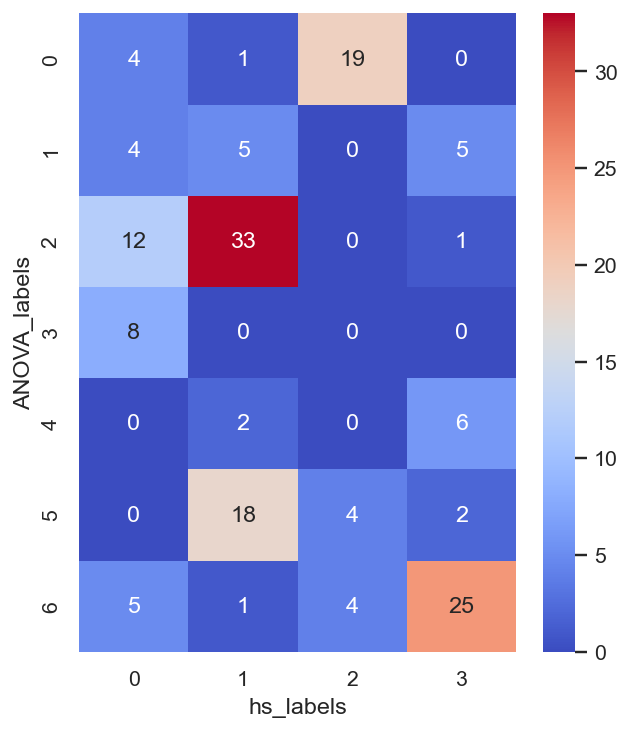

In [95]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

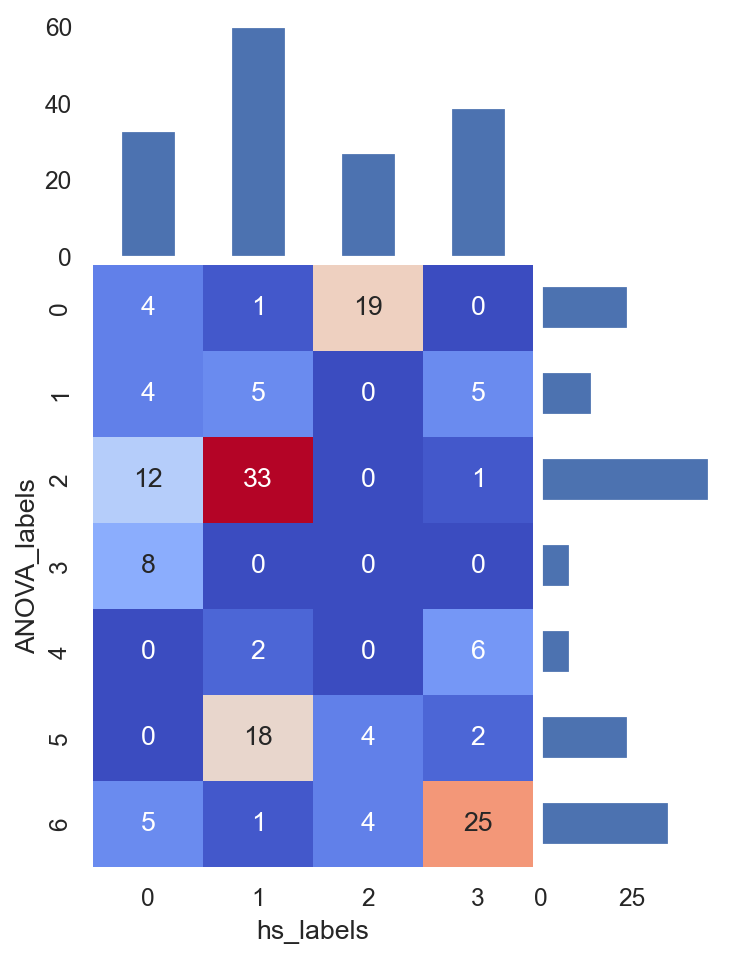

In [96]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [97]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/4 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [98]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [99]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
positive regulation of chemokine (C-X-C motif) ...     1  0.000074   
regulation of chemokine (C-X-C motif) ligand 2 ...     2  0.000185   
nervous system development (GO:0007399)                3  0.000440   
neuron projection morphogenesis (GO:0048812)           4  0.000488   
positive regulation of chemokine production (GO...     5  0.000948   

                                                       Z-score  \
Term                                                             
positive regulation of chemokine (C-X-C motif) ...  295.903226   
regulation of chemokine (C-X-C motif) ligand 2 ...  147.919355   
nervous system development (GO:0007399)               7.138387   
neuron projection morphogenesis (GO:0048812)         12.517241   
positive regulation of chemokine production (GO...   53.747801   

                                                    Combined score  \
Term                                                                 
positive regulation of chemokine (C-X-C motif) ...     2812.880346   
regulation of chemokine (C-X-C motif) ligand 2 ...     1271.259790   
nervous system development (GO:0007399)                  55.177392   
neuron projection morphogenesis (GO:0048812)             95.434736   
positive regulation of chemokine production (GO...      374.155406   

                                                                        Overlapping genes  \
Term                                                                                        
positive regulation of chemokine (C-X-C motif) ...                             [LPL, MBP]   
regulation of chemokine (C-X-C motif) ligand 2 ...                             [LPL, MBP]   
nervous system development (GO:0007399)             [ZEB2, GSN, MBP, S100B, SCRG1, DCLK1]   
neuron projection morphogenesis (GO:0048812)                  [MAP1B, MAP6, S100B, DCLK1]   
positive regulation of chemokine production (GO...                             [LPL, MBP]   

                                                    Adjusted P-value  \
Term                                                                   
positive regulation of chemokine (C-X-C motif) ...          0.031173   
regulation of chemokine (C-X-C motif) ligand 2 ...          0.038792   
nervous system development (GO:0007399)                     0.051166   
neuron projection morphogenesis (GO:0048812)                0.051166   
positive regulation of chemokine production (GO...          0.079019   

                                                    Old p-value  \
Term                                                              
positive regulation of chemokine (C-X-C motif) ...            0   
regulation of chemokine (C-X-C motif) ligand 2 ...            0   
nervous system development (GO:0007399)                       0   
neuron projection morphogenesis (GO:0048812)                  0   
positive regulation of chemokine production (GO...            0   

                                                    Old adjusted p-value  \
Term                                                                       
positive regulation of chemokine (C-X-C motif) ...                     0   
regulation of chemokine (C-X-C motif) ligand 2 ...                     0   
nervous system development (GO:0007399)                                0   
neuron projection morphogenesis (GO:0048812)                           0   
positive regulation of chemokine production (GO...                     0   

                                                    num_overlap_genes  \
Term                                                                    
positive regulation of chemokine (C-X-C motif) ...                  2   
regulation of chemokine (C-X-C motif) ligand 2 ...                  2   
nervous system development (GO:0007399)                             6   
neuron projection morphogenesis (GO:0048812)                        4   
positive 

In [100]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

38

In [101]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

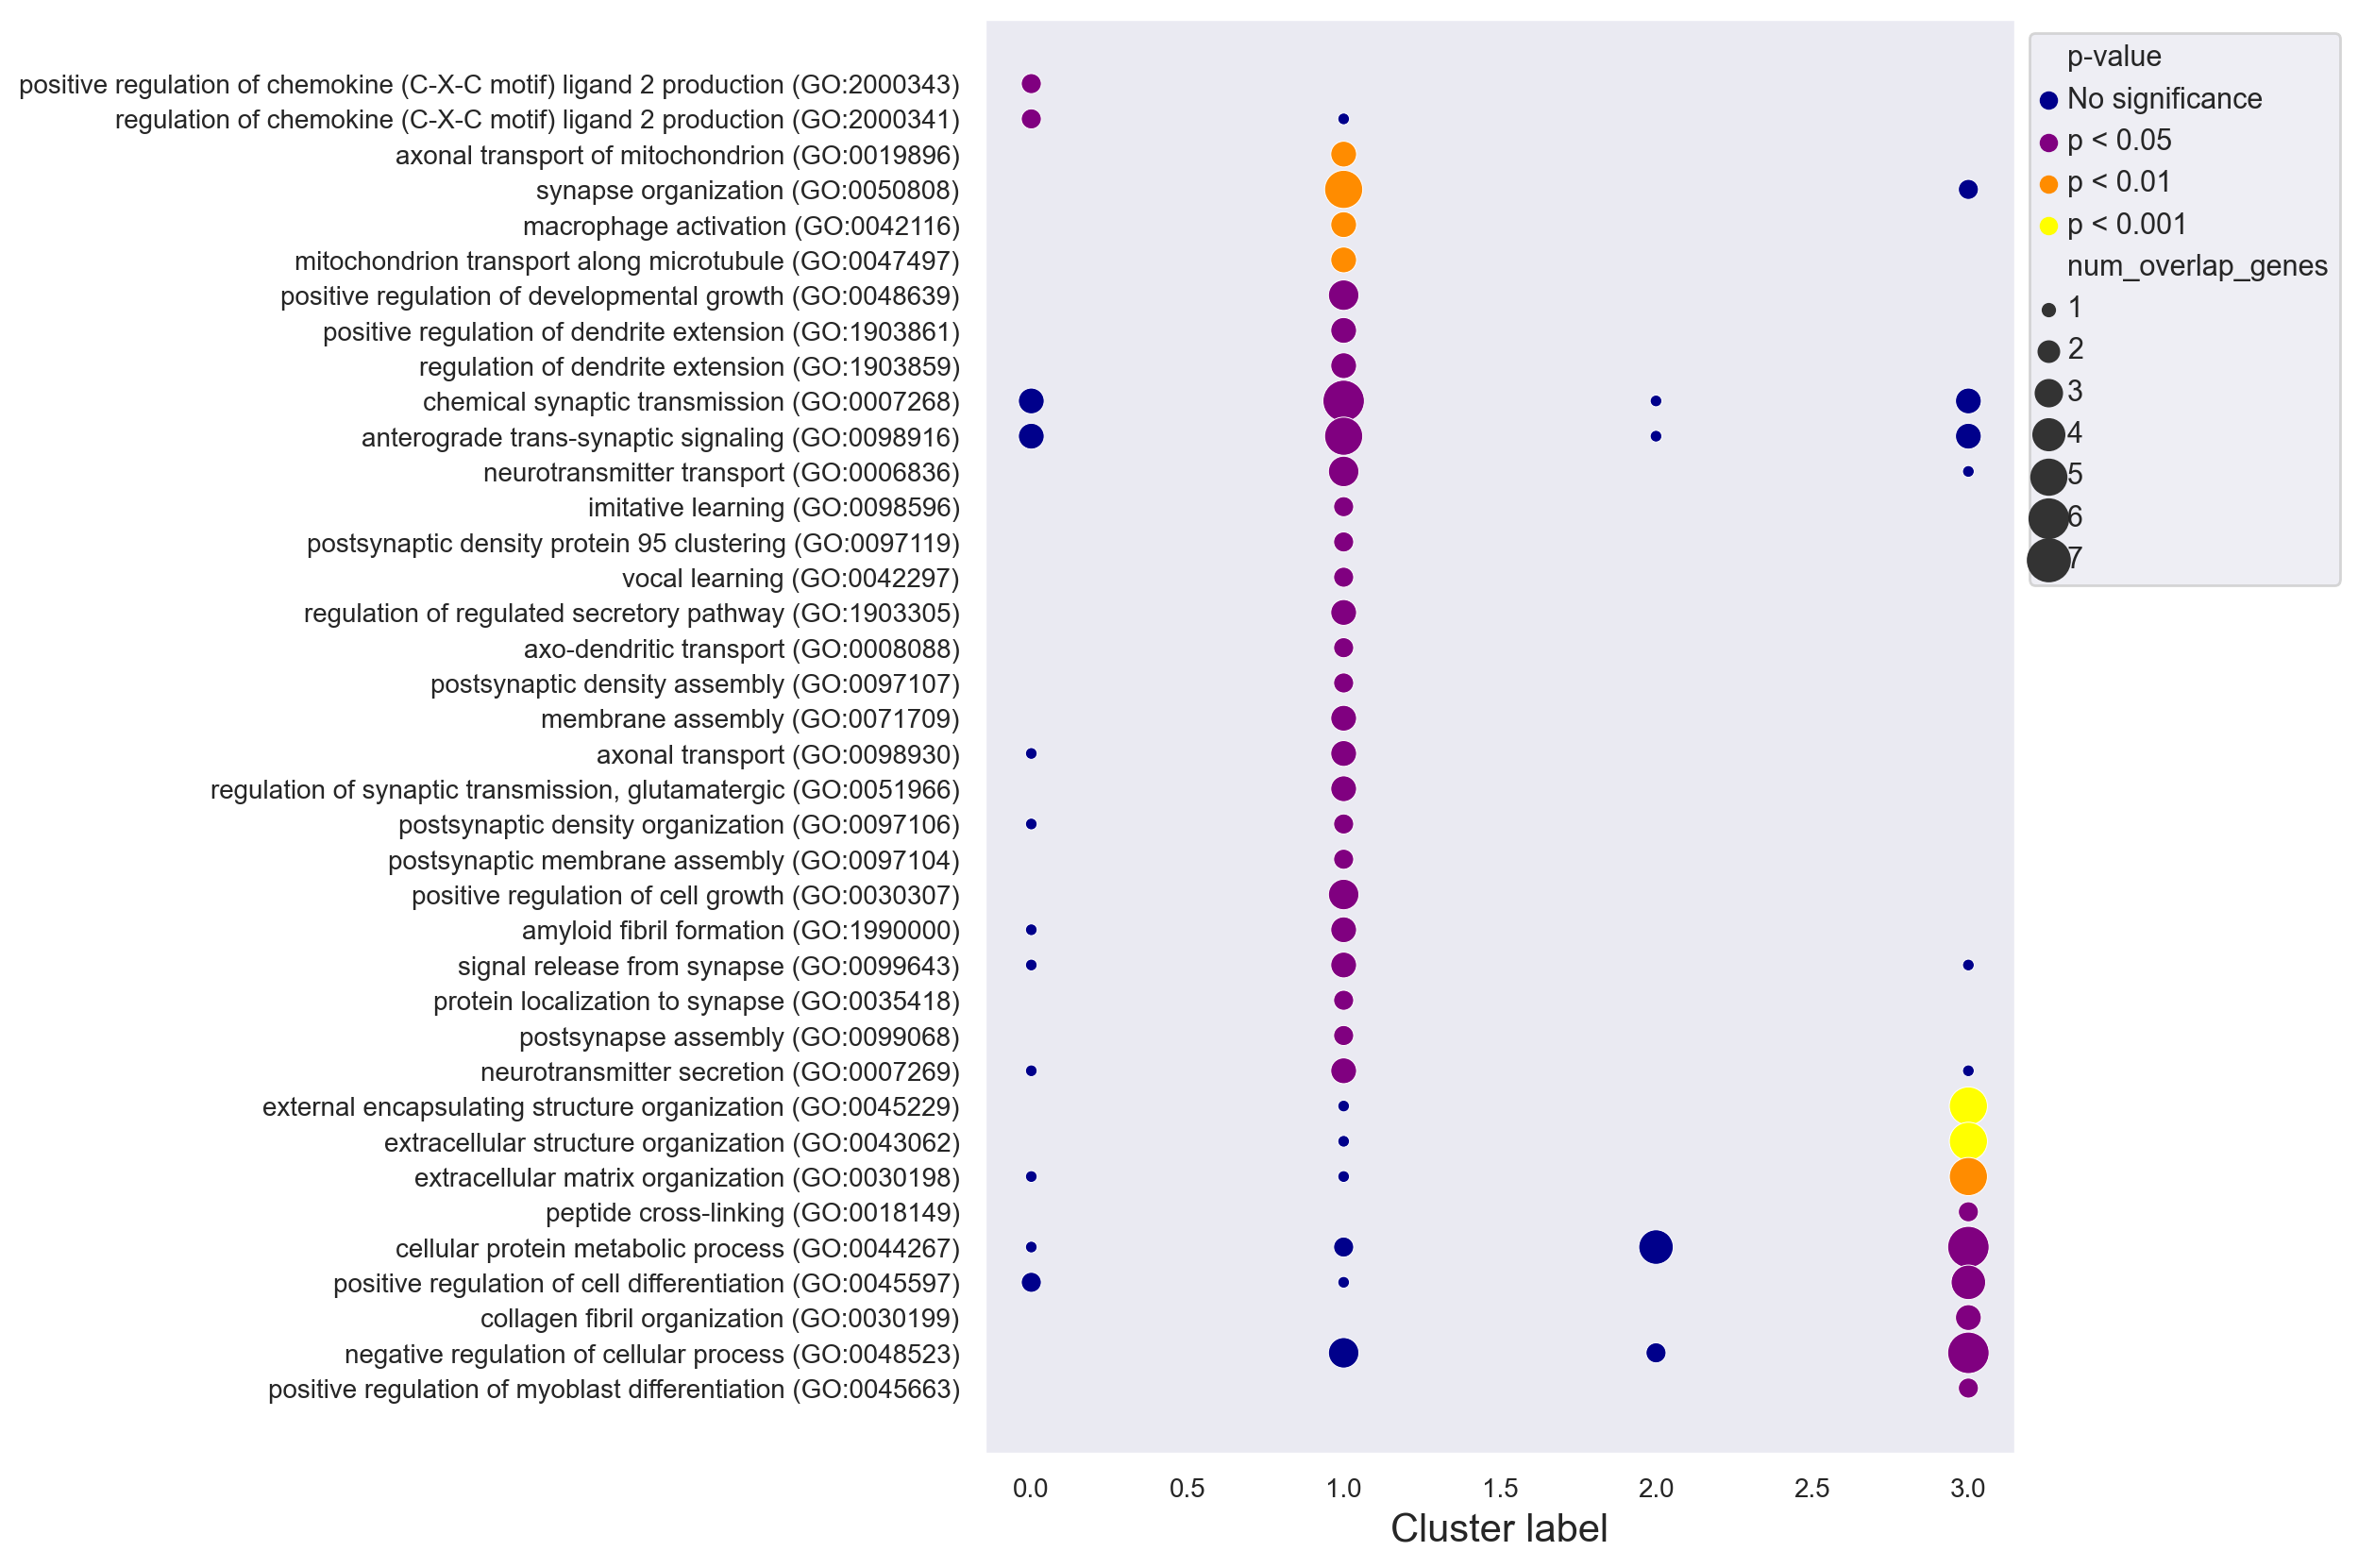

In [102]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [103]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [104]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  Combined score  \
Term                                                                          
Oligodendrocyte CL0000128           1  0.000344   98.591398      786.227740   
Schwann CL0002573                   2  0.007155  286.687500     1416.214536   
Beta Islet Cell CL0000169           3  0.010714  143.328125      650.164442   
Erythroid Cell CL0000764            4  0.010714  143.328125      650.164442   
Nonclassical Monocyte CL0000875     5  0.014261   95.541667      406.075983   

                                Overlapping genes  Adjusted P-value  \
Term                                                                  
Oligodendrocyte CL0000128             [PLP1, MBP]          0.008258   
Schwann CL0002573                          [PLP1]          0.025906   
Beta Islet Cell CL0000169                   [GSN]          0.025906   
Erythroid Cell CL0000764                  [TMCC2]          0.025906   
Nonclassical Monocyte CL0000875           [COTL1]          0.025906   

                                 Old p-value  Old adjusted p-value  \
Term                                                                 
Oligodendrocyte CL0000128                  0                     0   
Schwann CL0002573                          0                     0   
Beta Islet Cell CL0000169                  0                     0   
Erythroid Cell CL0000764                   0                     0   
Nonclassical Monocyte CL0000875            0                     0   

                                 num_overlap_genes  neg_log10(p_adj)  \
Term                                                                   
Oligodendrocyte CL0000128                        2          2.083117   
Schwann CL0002573                                1          1.586599   
Beta Islet Cell CL0000169                        1          1.586599   
Erythroid Cell CL0000764                         1          1.586599   
Nonclassical Monocyte CL0000875                  1          1.586599   

                                 cluster_label  
Term                                            
Oligodendrocyte CL0000128                    0  
Schwann CL0002573                            0  
Beta Islet Cell CL0000169                    0  
Erythroid Cell CL0000764                     0  
Nonclassical Monocyte CL0000875              0

In [105]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

29

In [106]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

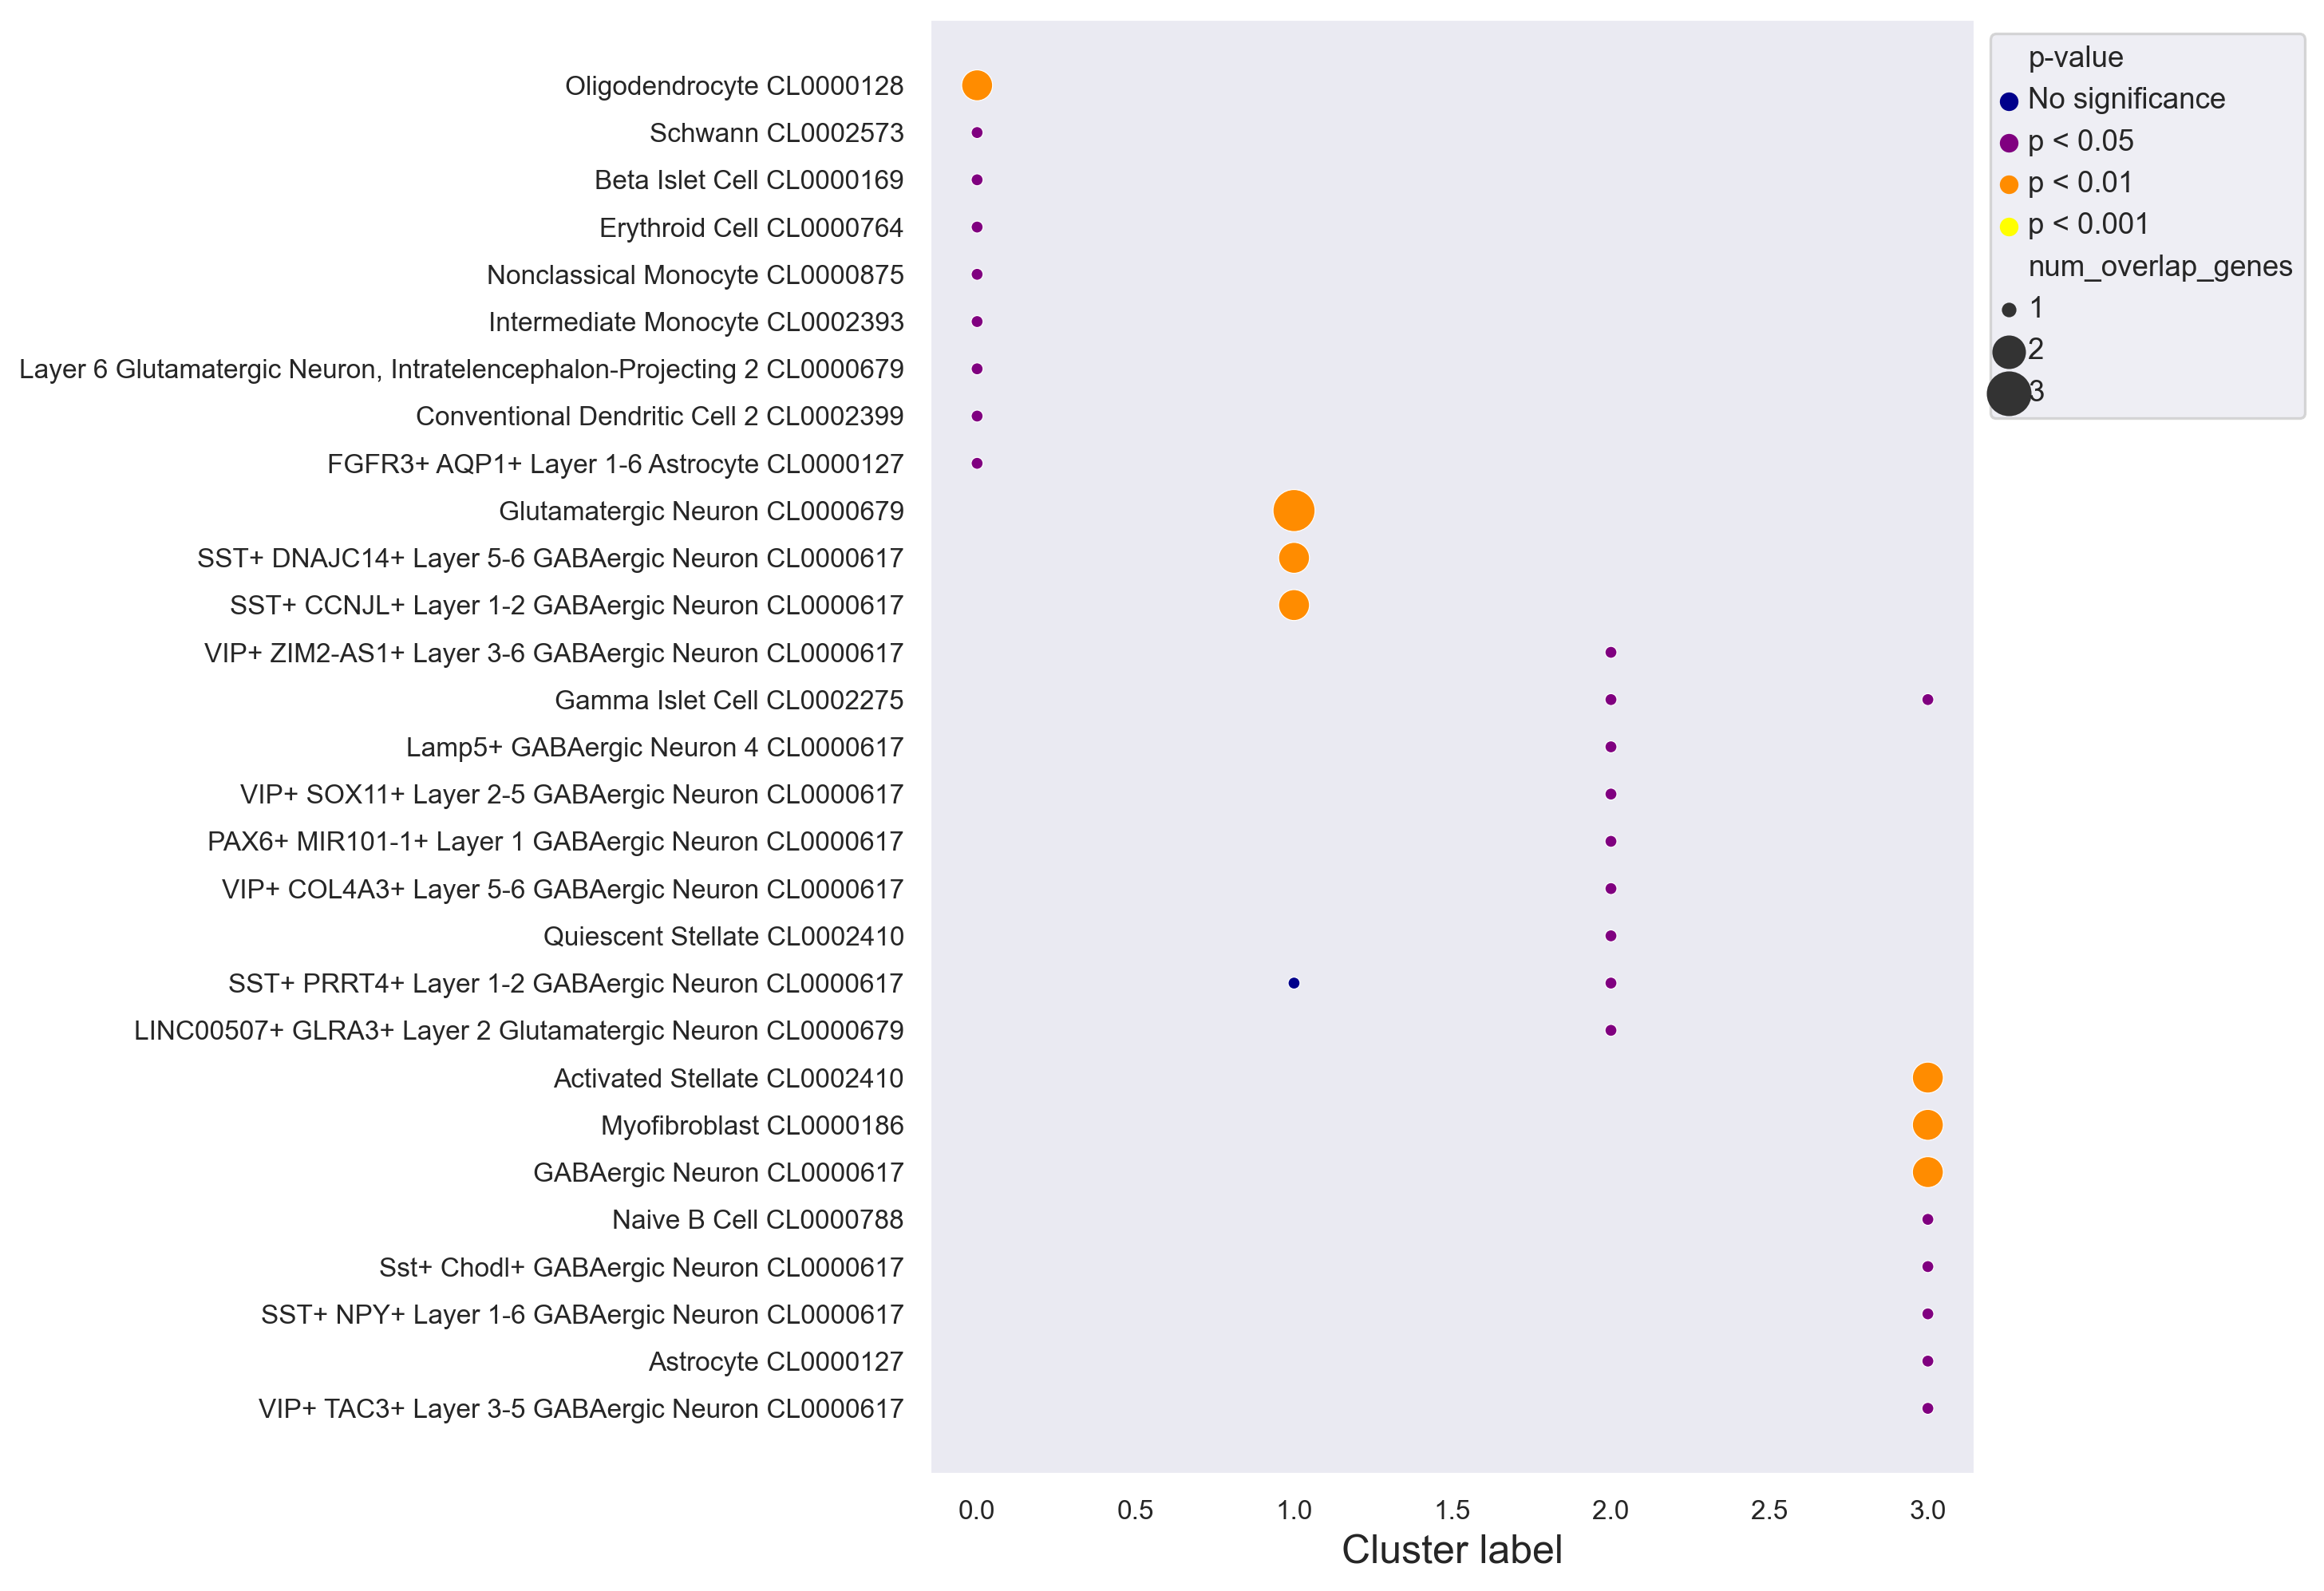

In [107]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [108]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [109]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
decreased corpus callosum size MP:0000781              1  0.000005   
abnormal oligodendrocyte morphology MP:0000953         2  0.000023   
abnormal myelination MP:0000920                        3  0.000047   
absent corpus callosum MP:0002196                      4  0.000062   
decreased susceptibility to Picornaviridae infe...     5  0.000074   

                                                       Z-score  \
Term                                                             
decreased corpus callosum size MP:0000781            45.059113   
abnormal oligodendrocyte morphology MP:0000953       70.476923   
abnormal myelination MP:0000920                      23.739753   
absent corpus callosum MP:0002196                    48.189474   
decreased susceptibility to Picornaviridae infe...  295.903226   

                                                    Combined score  \
Term                                                                 
decreased corpus callosum size MP:0000781               553.947505   
abnormal oligodendrocyte morphology MP:0000953          753.457943   
abnormal myelination MP:0000920                         236.455546   
absent corpus callosum MP:0002196                       467.144033   
decreased susceptibility to Picornaviridae infe...     2812.880346   

                                                            Overlapping genes  \
Term                                                                            
decreased corpus callosum size MP:0000781           [MAP1B, AKT3, ANK2, GFAP]   
abnormal oligodendrocyte morphology MP:0000953              [PLP1, MBP, GFAP]   
abnormal myelination MP:0000920                      [MAP1B, PLP1, MBP, GFAP]   
absent corpus callosum MP:0002196                        [MAP1B, AKT3, DCLK1]   
decreased susceptibility to Picornaviridae infe...                [PLP1, MBP]   

                                                    Adjusted P-value  \
Term                                                                   
decreased corpus callosum size MP:0000781                   0.001827   
abnormal oligodendrocyte morphology MP:0000953              0.004539   
abnormal myelination MP:0000920                             0.005937   
absent corpus callosum MP:0002196                           0.005937   
decreased susceptibility to Picornaviridae infe...          0.005937   

                                                    Old p-value  \
Term                                                              
decreased corpus callosum size MP:0000781                     0   
abnormal oligodendrocyte morphology MP:0000953                0   
abnormal myelination MP:0000920                               0   
absent corpus callosum MP:0002196                             0   
decreased susceptibility to Picornaviridae infe...            0   

                                                    Old adjusted p-value  \
Term                                                                       
decreased corpus callosum size MP:0000781                              0   
abnormal oligodendrocyte morphology MP:0000953                         0   
abnormal myelination MP:0000920                                        0   
absent corpus callosum MP:0002196                                      0   
decreased susceptibility to Picornaviridae infe...                     0   

                                                    num_overlap_genes  \
Term                                                                    
decreased corpus callosum size MP:0000781                           4   
abnormal oligodendrocyte morphology MP:0000953                      3   
abnormal myelination MP:0000920                                     4   
absent corpus callosum MP:0002196                                   3   
decreased susceptibility to Picornaviridae infe...                  2   

                   

In [110]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

47

In [111]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

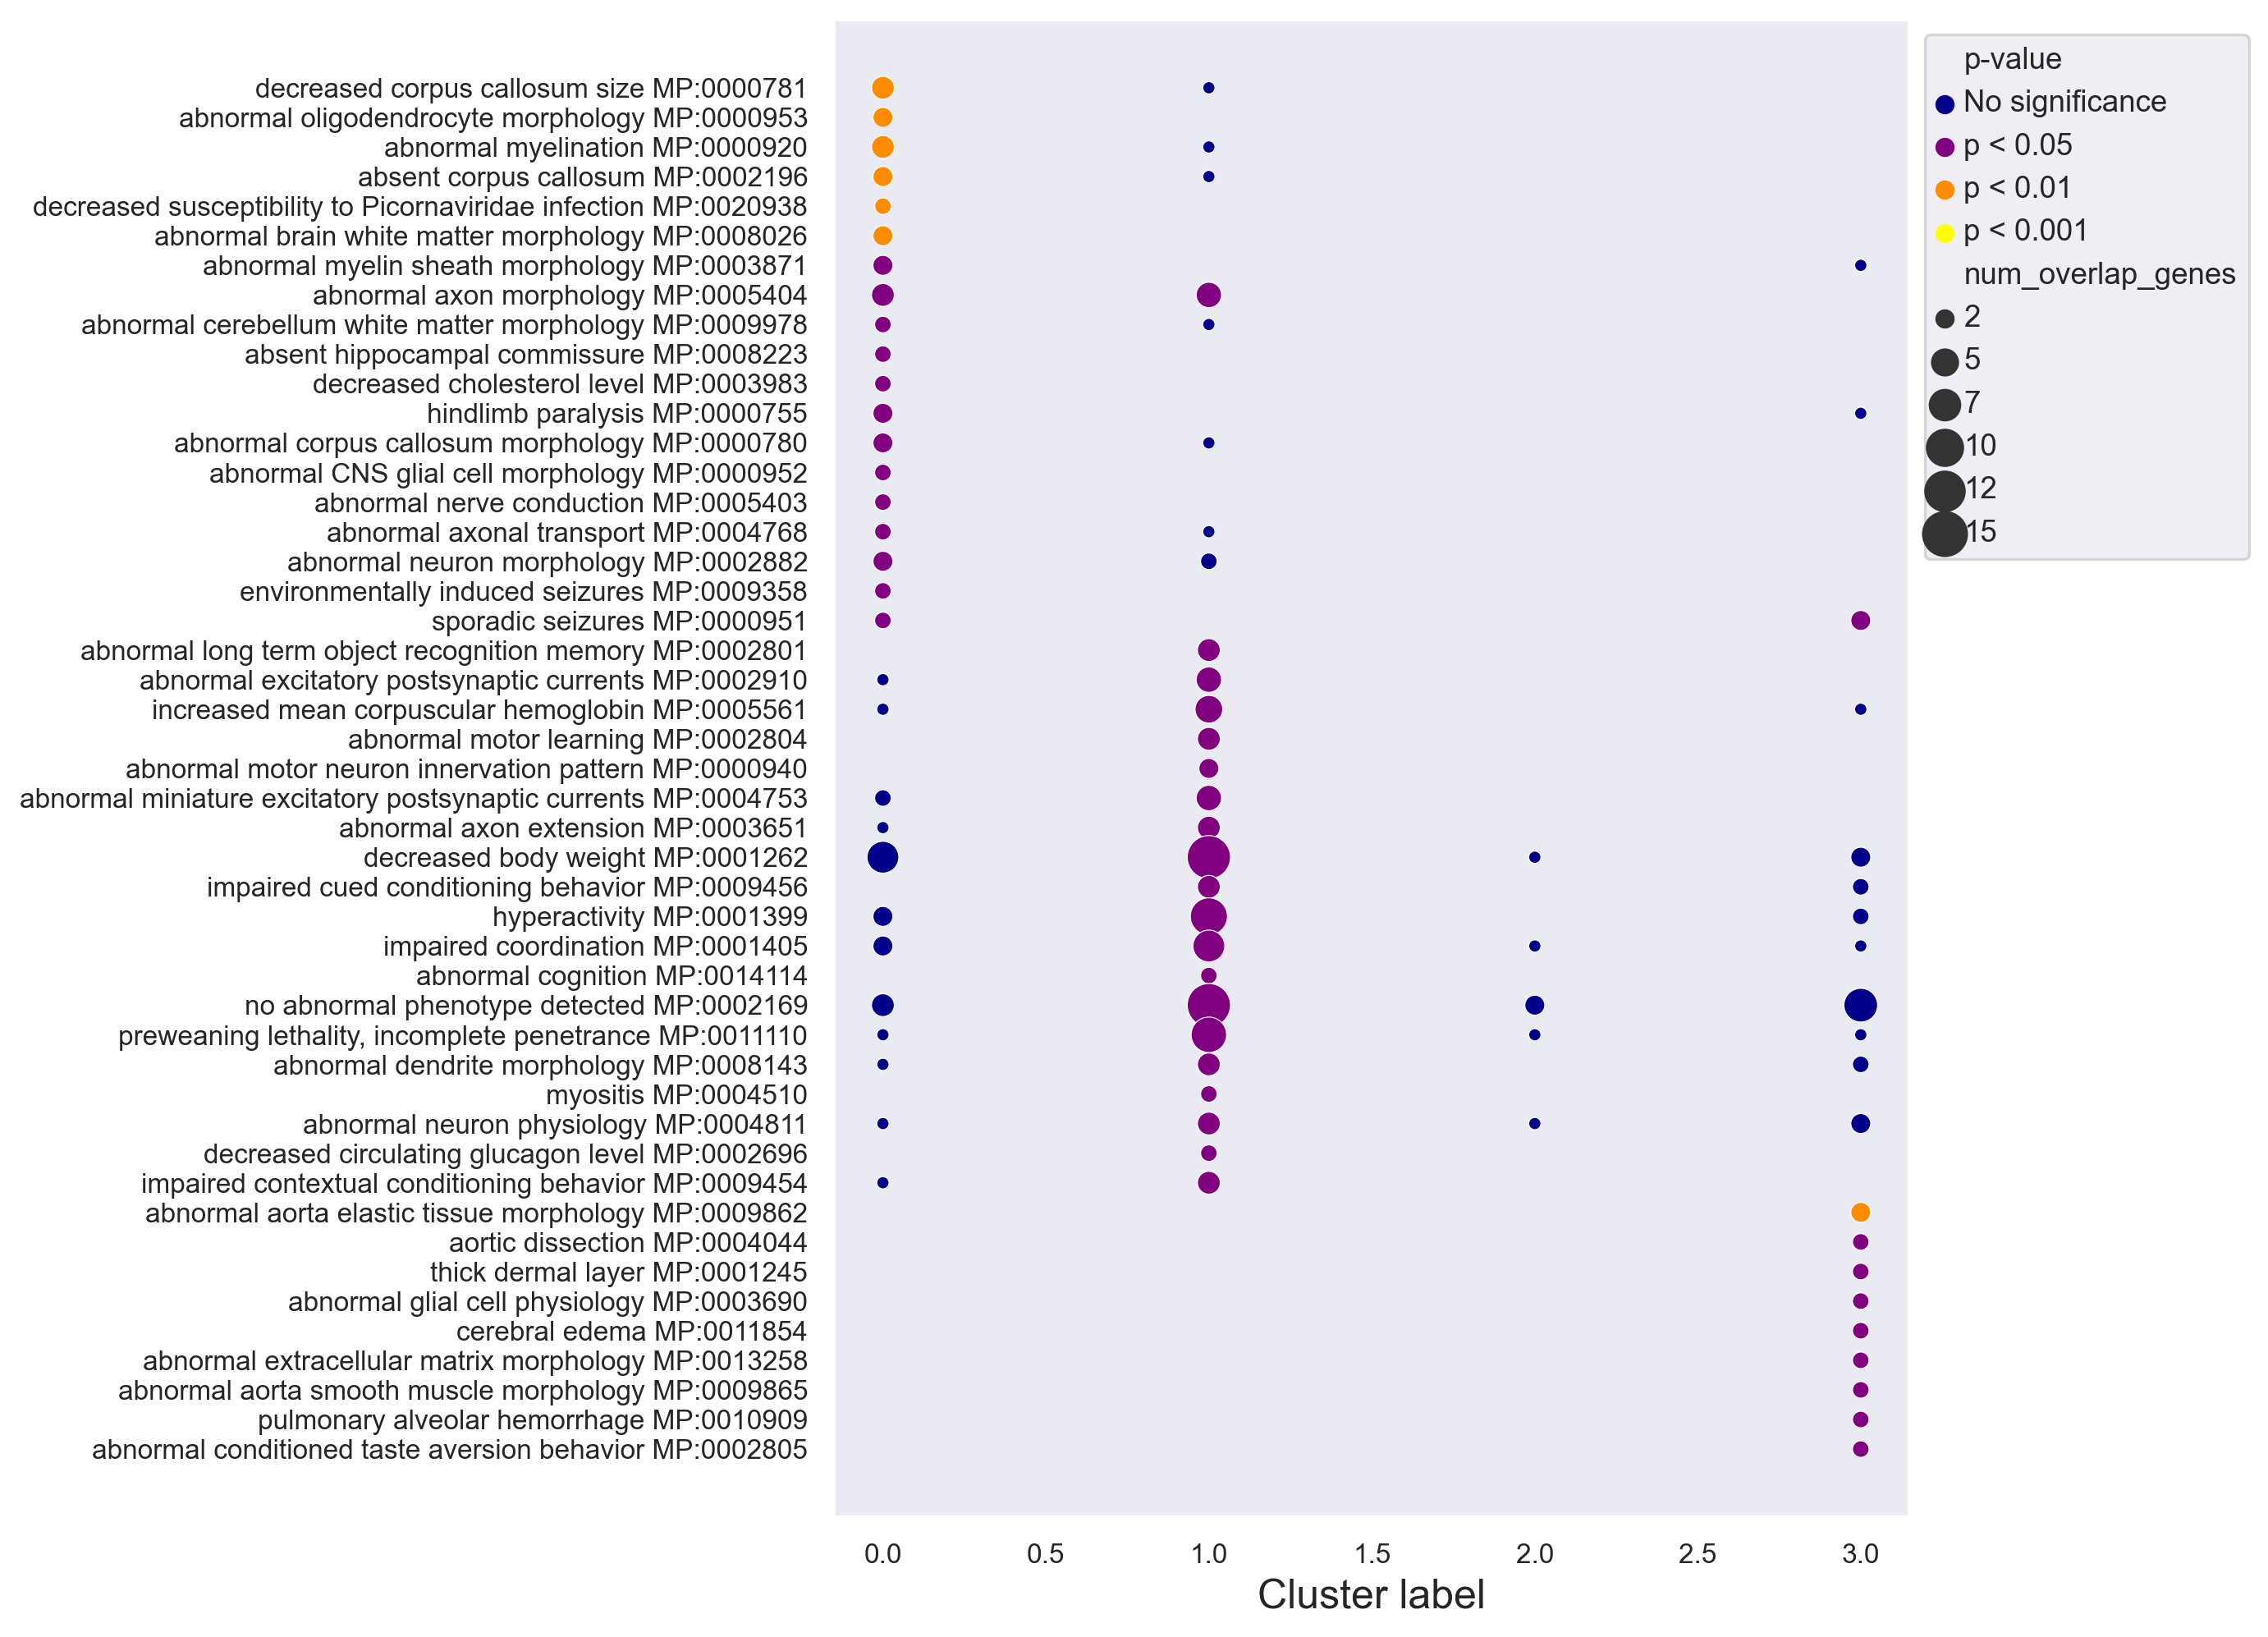

In [112]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [113]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [114]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  \
Term                                                                           
Interaction Between L1 And Ankyrins R-HSA-445095     1  0.002273   32.820789   
Sensory Perception R-HSA-9709957                     2  0.002856   11.815584   
Nuclear Signaling By ERBB4 R-HSA-1251985             3  0.003006   28.122888   
Chylomicron Remodeling R-HSA-8963901                 4  0.007155  286.687500   
Signaling By ERBB4 R-HSA-1236394                     5  0.008923   15.512733   

                                                  Combined score  \
Term                                                               
Interaction Between L1 And Ankyrins R-HSA-445095      199.769729   
Sensory Perception R-HSA-9709957                       69.220304   
Nuclear Signaling By ERBB4 R-HSA-1251985              163.310518   
Chylomicron Remodeling R-HSA-8963901                 1416.214536   
Signaling By ERBB4 R-HSA-1236394                       73.206200   

                                                  Overlapping genes  \
Term                                                                  
Interaction Between L1 And Ankyrins R-HSA-445095      [ANK2, SCN3A]   
Sensory Perception R-HSA-9709957                  [GSN, LPL, SCN3A]   
Nuclear Signaling By ERBB4 R-HSA-1251985              [S100B, GFAP]   
Chylomicron Remodeling R-HSA-8963901                          [LPL]   
Signaling By ERBB4 R-HSA-1236394                      [S100B, GFAP]   

                                                  Adjusted P-value  \
Term                                                                 
Interaction Between L1 And Ankyrins R-HSA-445095          0.184389   
Sensory Perception R-HSA-9709957                          0.184389   
Nuclear Signaling By ERBB4 R-HSA-1251985                  0.184389   
Chylomicron Remodeling R-HSA-8963901                      0.233637   
Signaling By ERBB4 R-HSA-1236394                          0.233637   

                                                  Old p-value  \
Term                                                            
Interaction Between L1 And Ankyrins R-HSA-445095            0   
Sensory Perception R-HSA-9709957                            0   
Nuclear Signaling By ERBB4 R-HSA-1251985                    0   
Chylomicron Remodeling R-HSA-8963901                        0   
Signaling By ERBB4 R-HSA-1236394                            0   

                                                  Old adjusted p-value  \
Term                                                                     
Interaction Between L1 And Ankyrins R-HSA-445095                     0   
Sensory Perception R-HSA-9709957                                     0   
Nuclear Signaling By ERBB4 R-HSA-1251985                             0   
Chylomicron Remodeling R-HSA-8963901                                 0   
Signaling By ERBB4 R-HSA-1236394                                     0   

                                                  num_overlap_genes  \
Term                                                                  
Interaction Between L1 And Ankyrins R-HSA-445095                  2   
Sensory Perception R-HSA-9709957                                  3   
Nuclear Signaling By ERBB4 R-HSA-1251985                          2   
Chylomicron Remodeling R-HSA-8963901                              1   
Signaling By ERBB4 R-HSA-1236394                                  2   

                                                  neg_log10(p_adj)  \
Term                                                                 
Interaction Between L1 And Ankyrins R-HSA-445095          0.734266   
Sensory Perception R-HSA-9709957                          0.734266   
Nuclear Signaling By ERBB4 R-HSA-1251985                  0.734266   
Chylomicron Remodeling R-HSA-8963901                      0.631458   
Signaling By ERBB4 R-HSA-1236394                          0.631458   

                                                  cluster_l

In [115]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

28

In [116]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

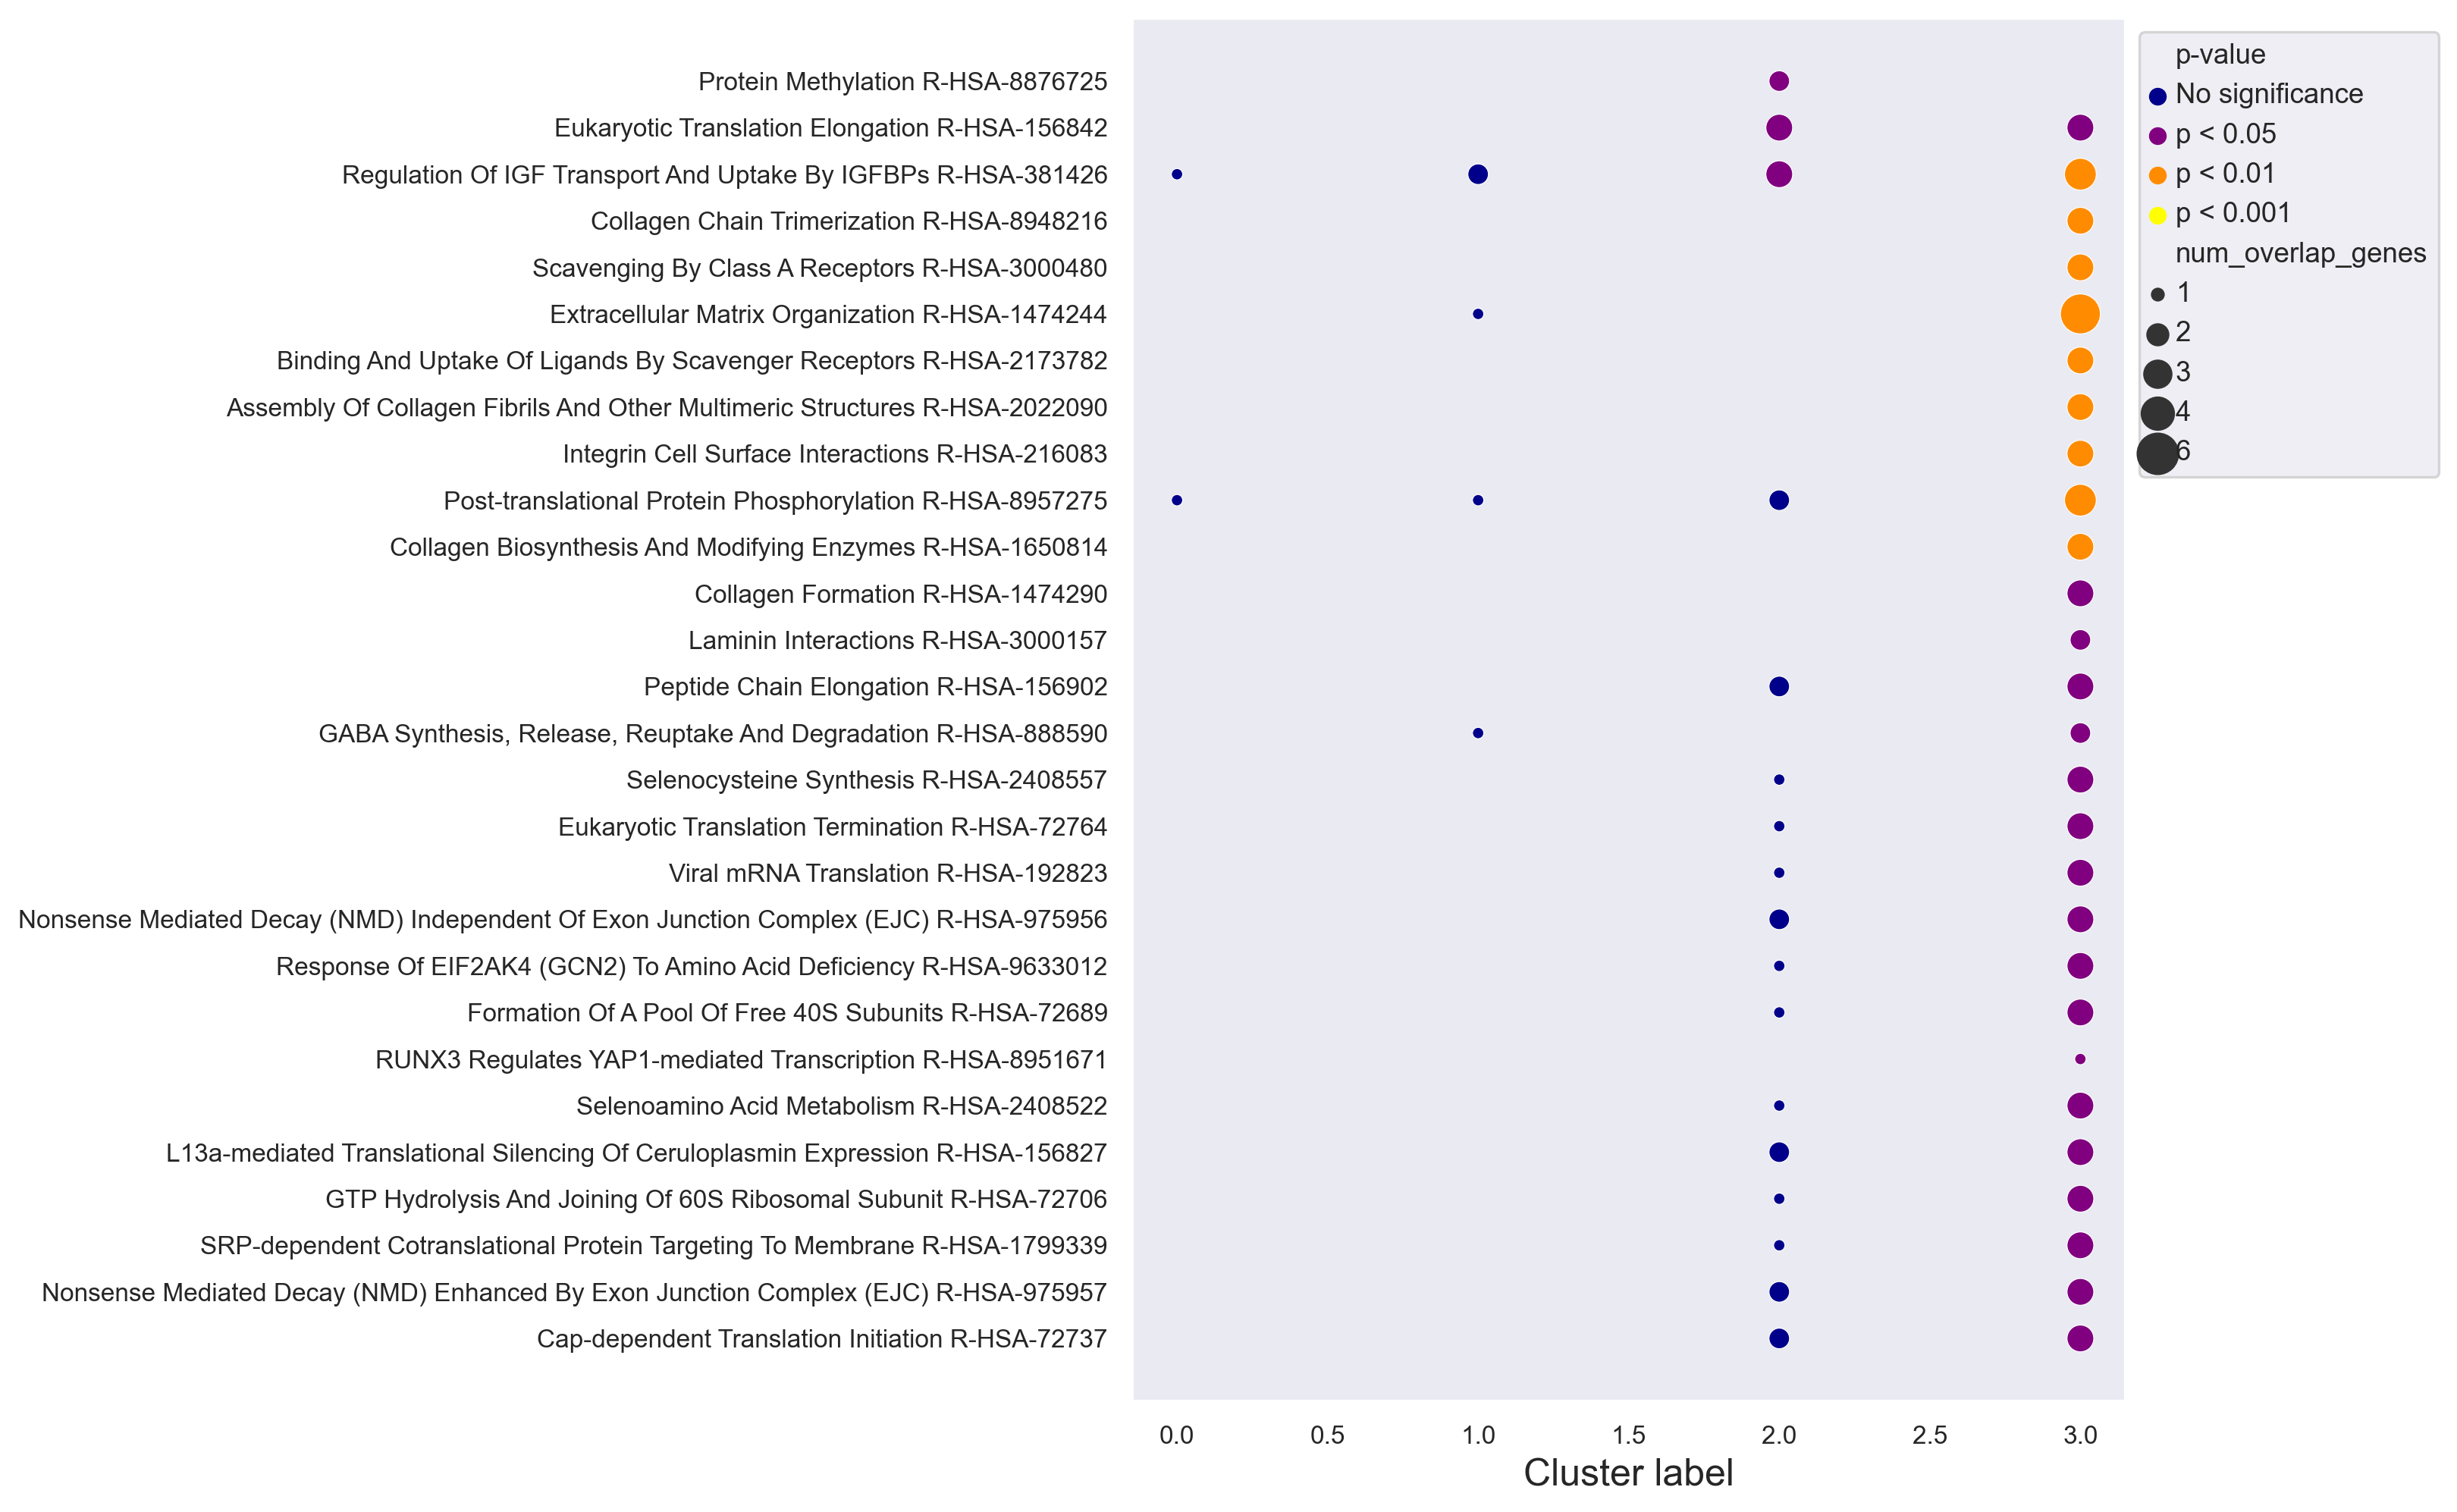

In [117]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [118]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [119]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val    Z-score  Combined score  \
Term                                                                    
Cholesterol metabolism         1  0.003006  28.122888      163.310518   
Taste transduction             2  0.004134  23.612903      129.601372   
PPAR signaling pathway         3  0.006883  17.872923       88.983572   
JAK-STAT signaling pathway     4  0.017580  10.697947       43.230246   
Cell adhesion molecules        5  0.018168  10.505760       42.108303   

                           Overlapping genes  Adjusted P-value  Old p-value  \
Term                                                                          
Cholesterol metabolism           [LPL, TSPO]          0.245955            0   
Taste transduction            [PDE1A, SCN3A]          0.245955            0   
PPAR signaling pathway          [FADS2, LPL]          0.273031            0   
JAK-STAT signaling pathway      [AKT3, GFAP]          0.362387            0   
Cell adhesion molecules       [CLDN11, NEO1]          0.362387            0   

                            Old adjusted p-value  num_overlap_genes  \
Term                                                                  
Cholesterol metabolism                         0                  2   
Taste transduction                             0                  2   
PPAR signaling pathway                         0                  2   
JAK-STAT signaling pathway                     0                  2   
Cell adhesion molecules                        0                  2   

                            neg_log10(p_adj)  cluster_label  
Term                                                         
Cholesterol metabolism              0.609144              0  
Taste transduction                  0.609144              0  
PPAR signaling pathway              0.563788              0  
JAK-STAT signaling pathway          0.440827              0  
Cell adhesion molecules             0.440827              0

In [120]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

2

In [121]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

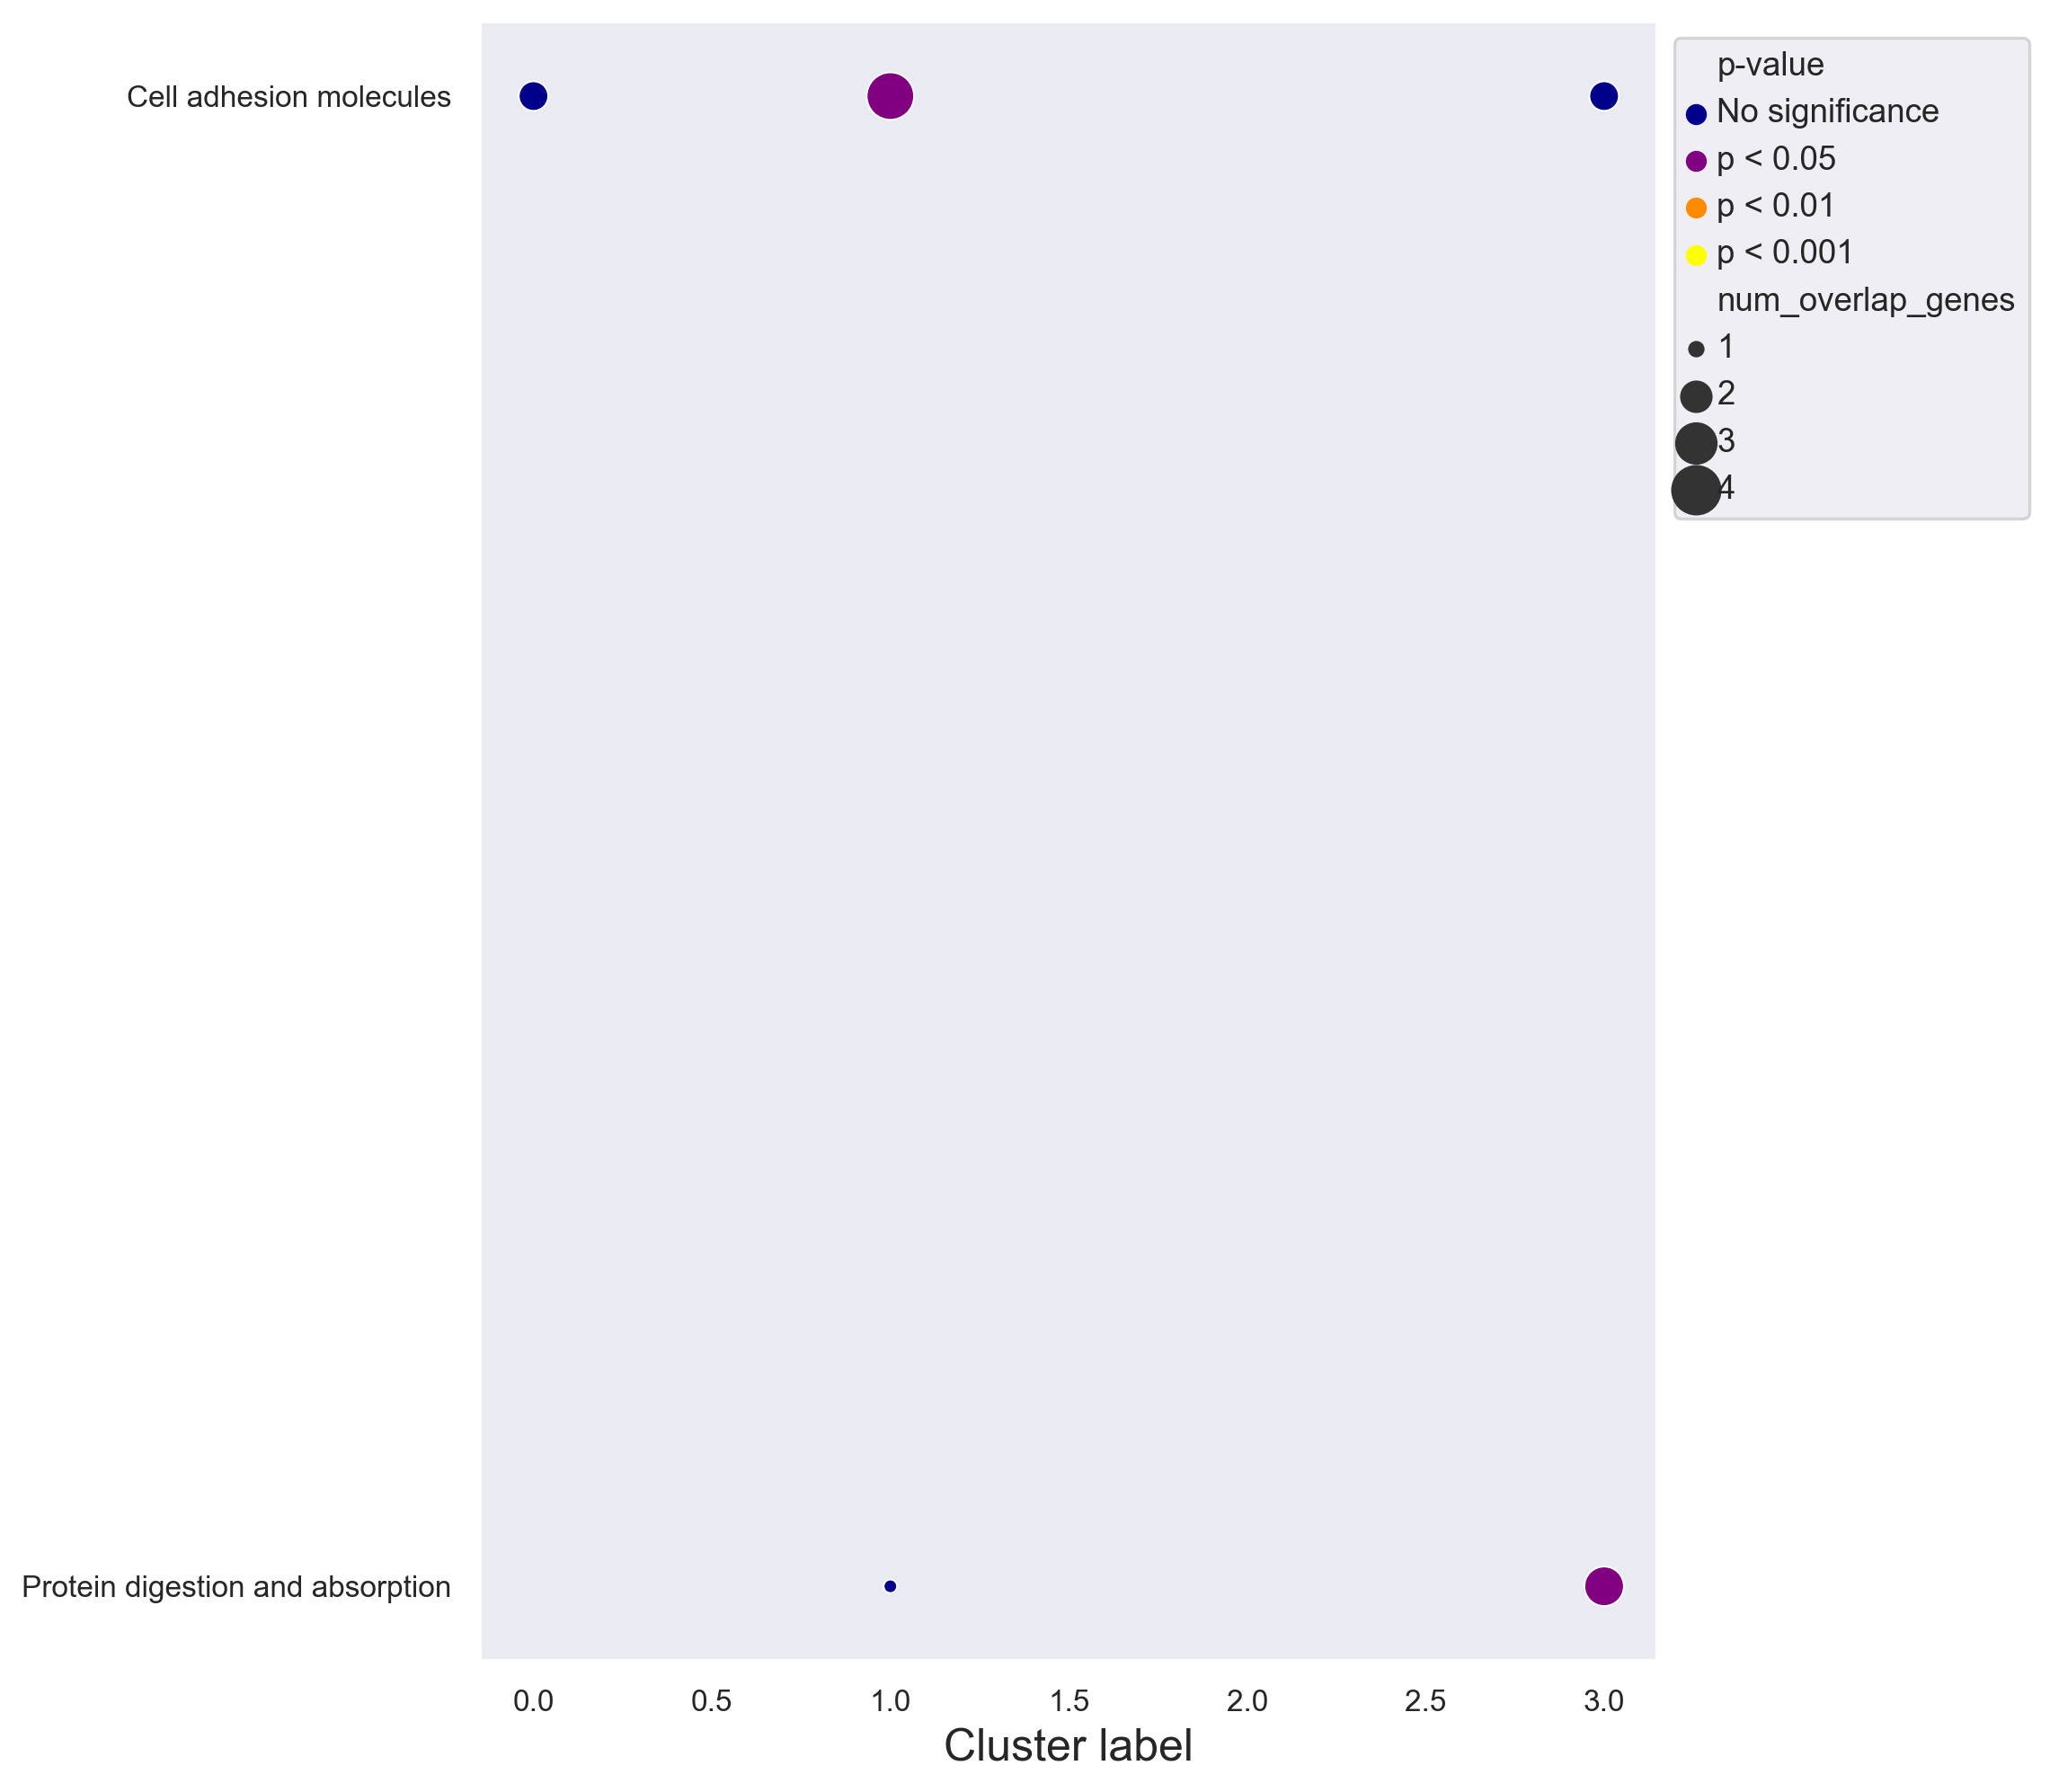

In [122]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))